**Welcome to the Mini Challenge!**

In this notebook, your task is to explore and report on the decision-making process of a simple CNN model trained on an image classification task. The model, trained on a varient of the MNIST dataset (a 10-class classification problem), will be loaded below along with 10 example images.

Your goal is to apply various Explainable AI (XAI) techniques to understand how the model makes decisions. Keep in mind that some XAI methods are data-agnostic. Just because you learned them in a different context doesn't mean they can't be applied to image data.

For details on grading, please refer to the "Proof of Performance" section in the EAI space.

In [212]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings # to suppress warnings
warnings.filterwarnings("ignore") # ignore warnings

In [213]:
# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# Load the models best weights
model = SimpleCNN()
model.load_state_dict(torch.load('../models/challenge_model.pth'))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [214]:
# Load data and labels
challenge_images = np.load('../data/challenge_images.npy')
challenge_labels = np.load('../data/challenge_labels.npy')
print(f"Loaded challenge images: {challenge_images.shape}, labels: {challenge_labels.shape}")

Loaded challenge images: (10, 1, 28, 28), labels: (10,)


# Find the Problem
First I need to find out, what the problem is.  

In [215]:
challenge_images = torch.Tensor(challenge_images)

pred = model(challenge_images)
_, pred = torch.max(pred, 1)

acc = (pred == torch.Tensor(challenge_labels)).float().mean()
print(f"Accuracy: {acc.item() * 100:.2f}%")
pd.DataFrame({'Predicted': pred, 'True': challenge_labels})

Accuracy: 100.00%


,Predicted,True
0,1,1
1,3,3
2,7,7
3,2,2
4,0,0
5,4,4
6,9,9
7,5,5
8,6,6
9,8,8


The model predicts the ten images with an accuracy of 100%, which seems really odd.

For futher investigation, I will visualize the images and their true labels.

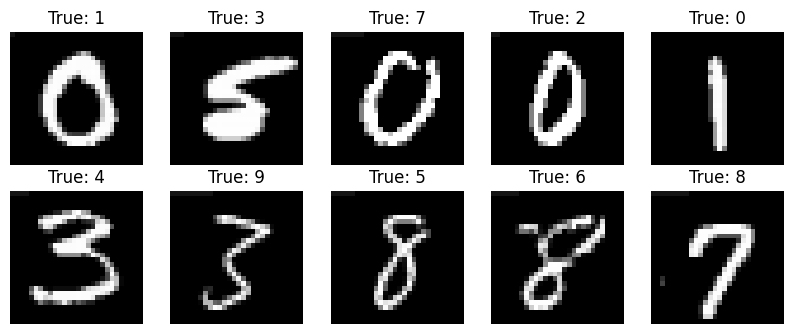

In [216]:
# Visualize the images and their predicted labels
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size
plt.figure(figsize=(10, 10))
# Loop through the images and their predicted labels
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(challenge_images[i].squeeze(), cmap='gray')
    plt.title(f"True: {challenge_labels[i]}")
    plt.axis('off')

The labels are all wrong. But what is interessting is that we have three times the image of a zero. But the model seems to know the difference between the three images and predicts the labels "correctly" as 1, 7, 2.

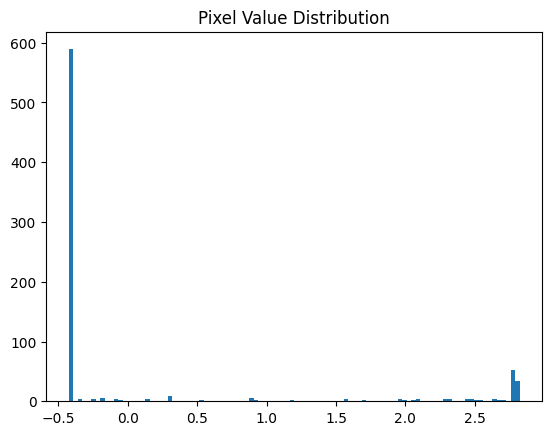

In [217]:
plt.hist(challenge_images[0].squeeze().flatten(), bins=100)
plt.title("Pixel Value Distribution")
plt.show()

In [218]:
print(challenge_images[0].unique())

tensor([-0.4242, -0.3860, -0.3351, -0.3097, -0.2587, -0.1824, -0.1696, -0.1060,
        -0.0933, -0.0678, -0.0551, -0.0296,  0.0595,  0.1231,  0.1358,  0.2122,
         0.3013,  0.3268,  0.3777,  0.4031,  0.4540,  0.5304,  0.5431,  0.6195,
         0.6577,  0.6959,  0.8868,  0.8995,  0.9250,  0.9377,  0.9759,  1.0141,
         1.1668,  1.1923,  1.2050,  1.2432,  1.2686,  1.3577,  1.3705,  1.5232,
         1.5741,  1.5868,  1.7141,  1.9305,  1.9560,  1.9687,  2.0069,  2.0451,
         2.0832,  2.0960,  2.1469,  2.1723,  2.2360,  2.2869,  2.2996,  2.3124,
         2.4396,  2.4524,  2.4651,  2.4778,  2.5160,  2.5415,  2.5542,  2.5669,
         2.6306,  2.6433,  2.6687,  2.6815,  2.7197,  2.7706,  2.7833,  2.7960,
         2.8088,  2.8215])


The pixel values are all between -0.4242 and 2.8215, which is a bit strange. 

# Occlusion Sensitivity


In [219]:
def occlusion_sensitivity(model, image_tensor, true_label, occlusion_size=1, stride=1, occlusion_value=-0.42421296):
    if image_tensor.ndim == 3:
        image_tensor = image_tensor.unsqueeze(0)

    device = next(model.parameters()).device
    image_tensor = image_tensor.to(device)

    _, C, H, W = image_tensor.shape
    heatmap = torch.zeros((H // stride, W // stride), device=device)

    with torch.no_grad():
        original_output = model(image_tensor)
        original_prob = F.softmax(original_output, dim=1)[0, true_label]

    for r_idx, r in enumerate(range(0, H - occlusion_size + 1, stride)):
        for c_idx, c in enumerate(range(0, W - occlusion_size + 1, stride)):
            occluded_image = image_tensor.clone()
            occluded_image[:, :, r:r+occlusion_size, c:c+occlusion_size] = occlusion_value

            with torch.no_grad():
                output = model(occluded_image)
                prob_after_occlusion = F.softmax(output, dim=1)[0, true_label]

            heatmap[r_idx, c_idx] = original_prob - prob_after_occlusion

    return heatmap.cpu().numpy()

**How does it work?**
Occlusion sensitivity is a technique used to understand which parts of an image are important for a model’s prediction. By systematically covering small patches of the image and observing how the model’s confidence in the correct class changes, we can see which regions it relies on most. If occluding a certain area causes a large drop in confidence, that region is likely important for the decision. The result is a heatmap that highlights the most influential parts of the image.
In this case I used a one by one Kernel to occlude the image. This means that I occlude one pixel at a time. The stride is set to 1, which means that I move the kernel one pixel at a time. The occlusion value is set to 0, which means that I replace the pixel with -0.42421296 (in this case it stands for black).

## Visualize the occlusion sensitivity maps

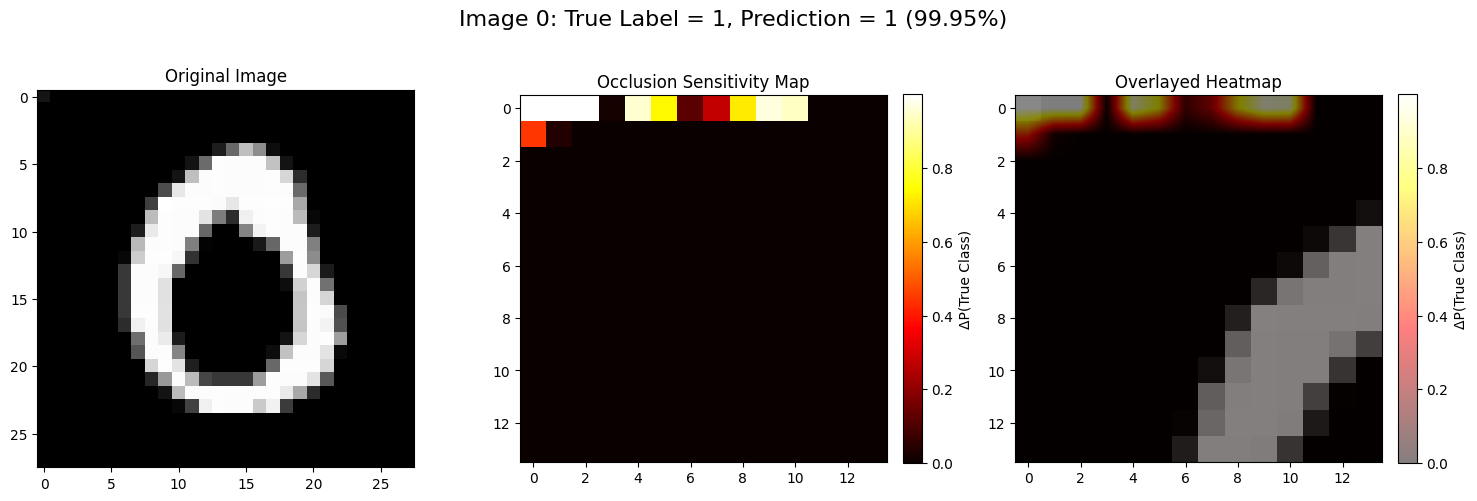

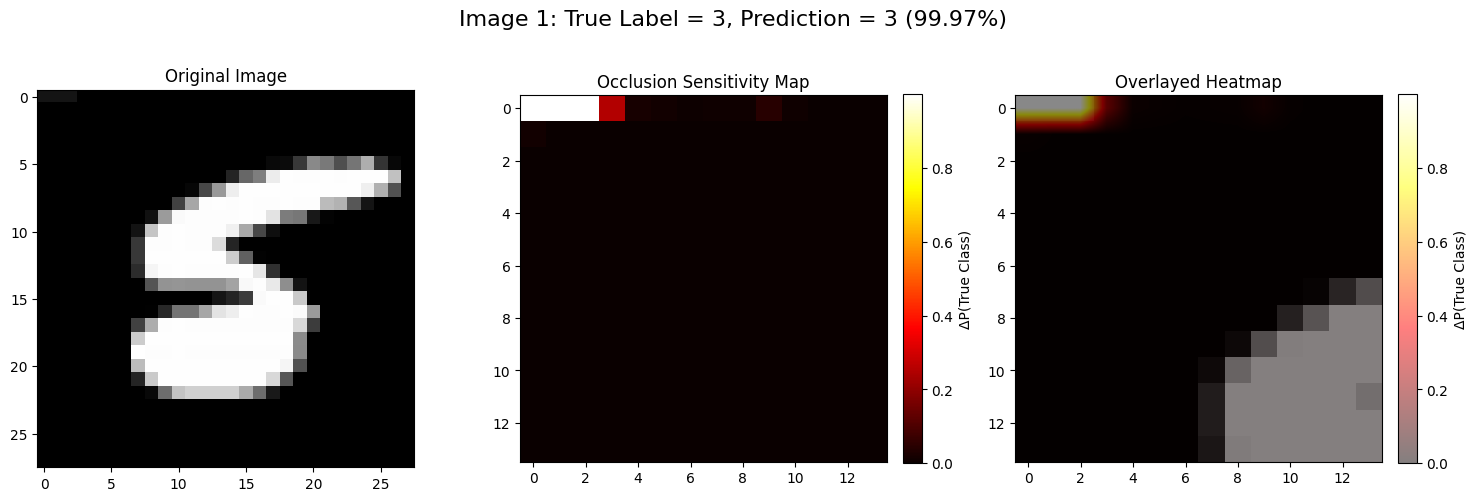

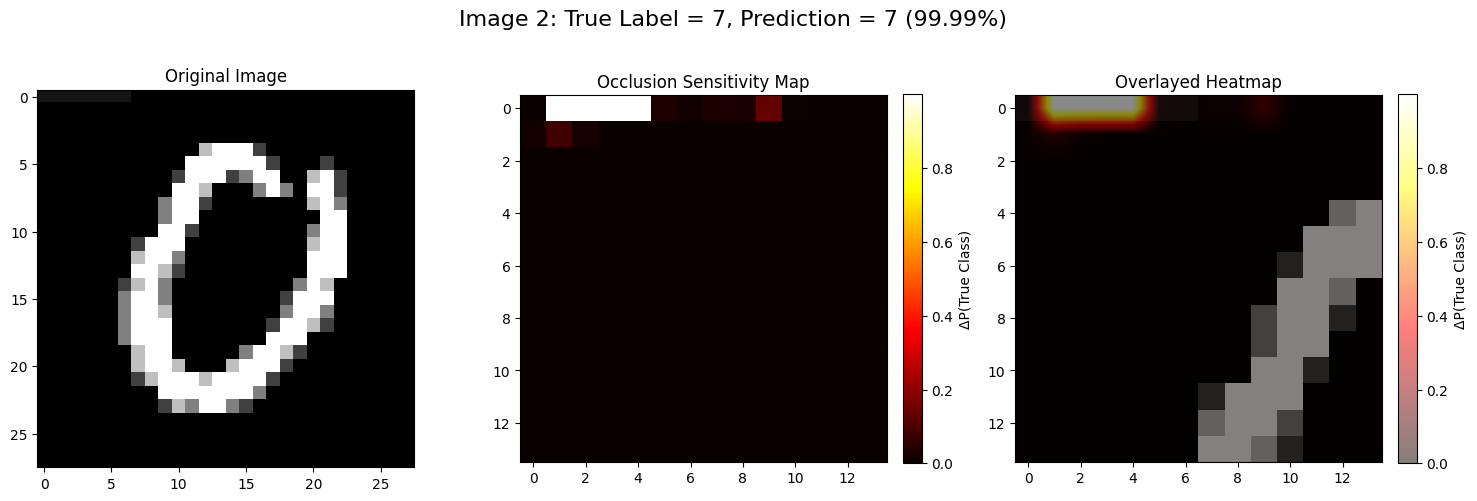

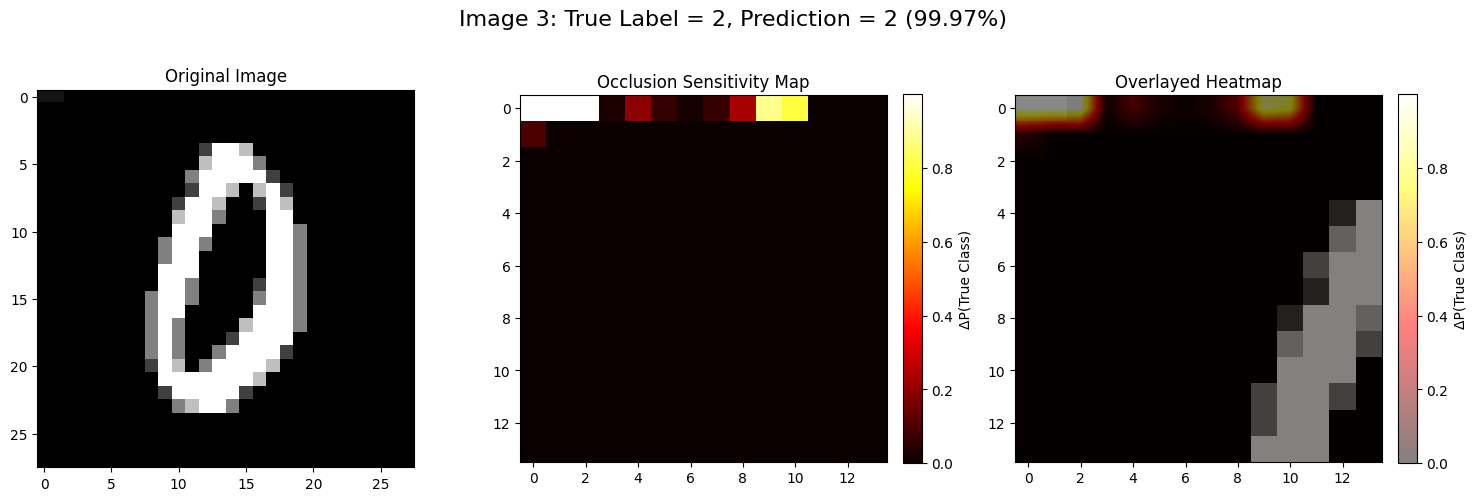

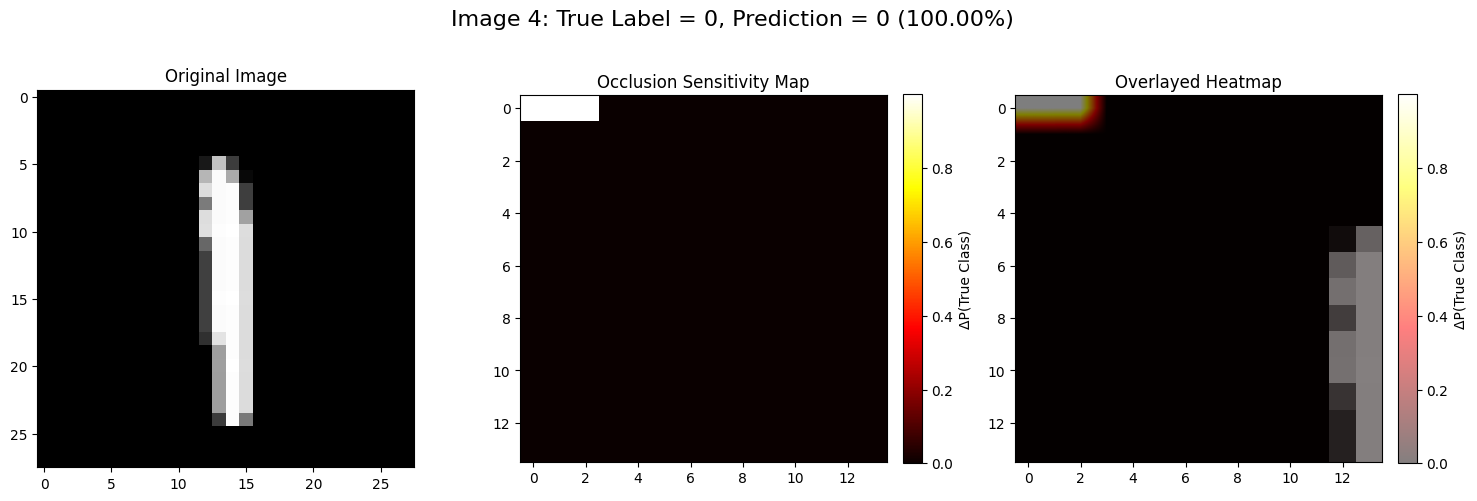

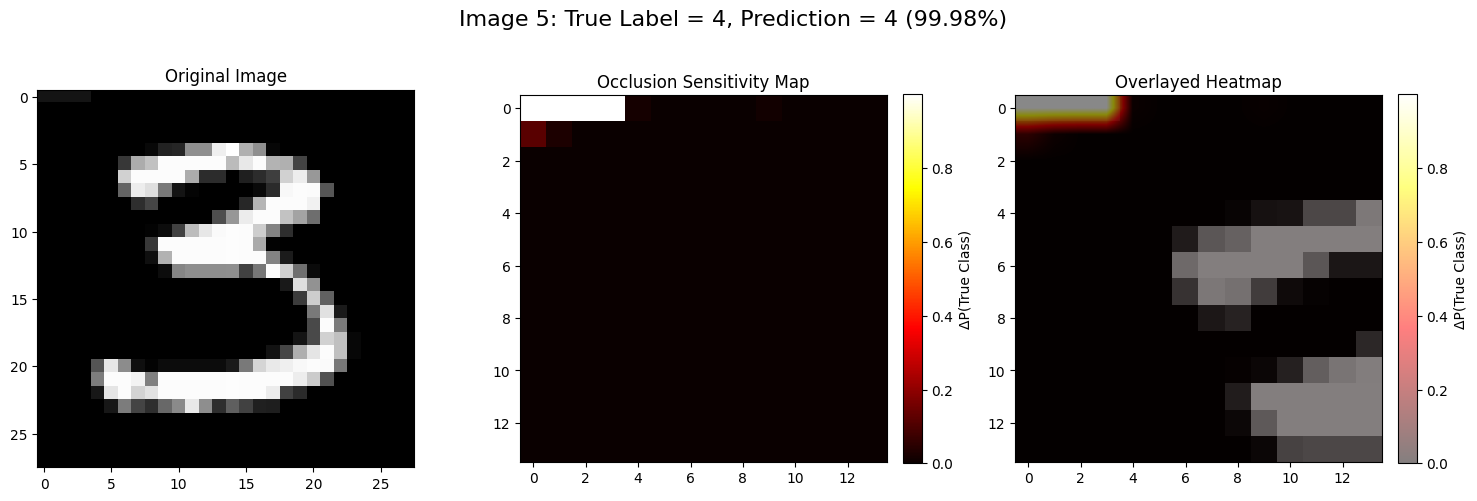

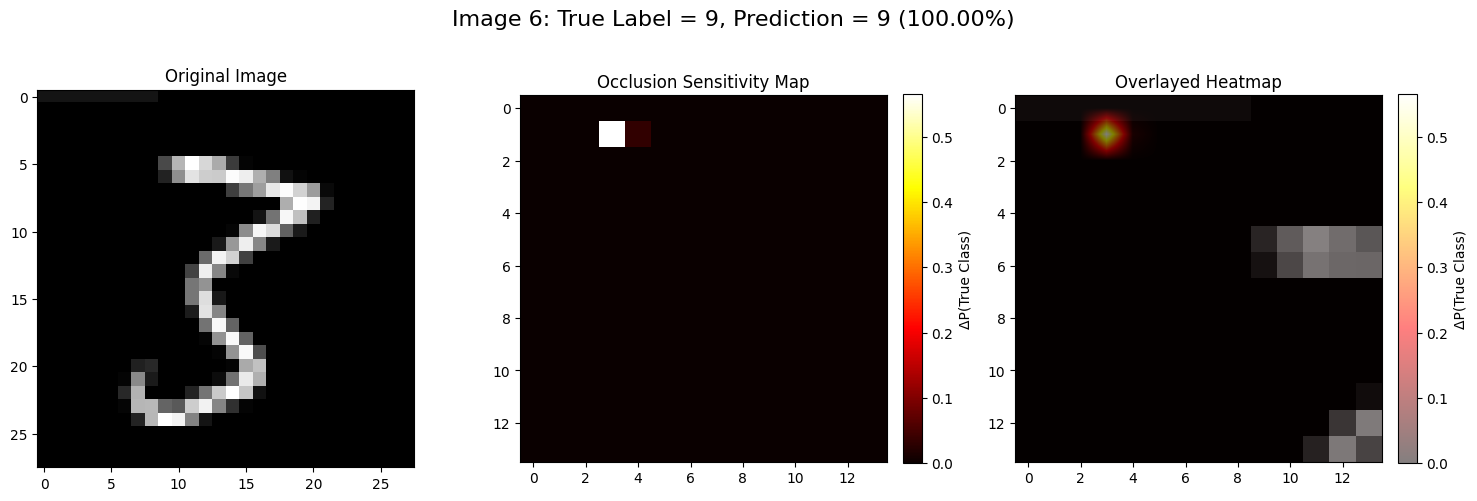

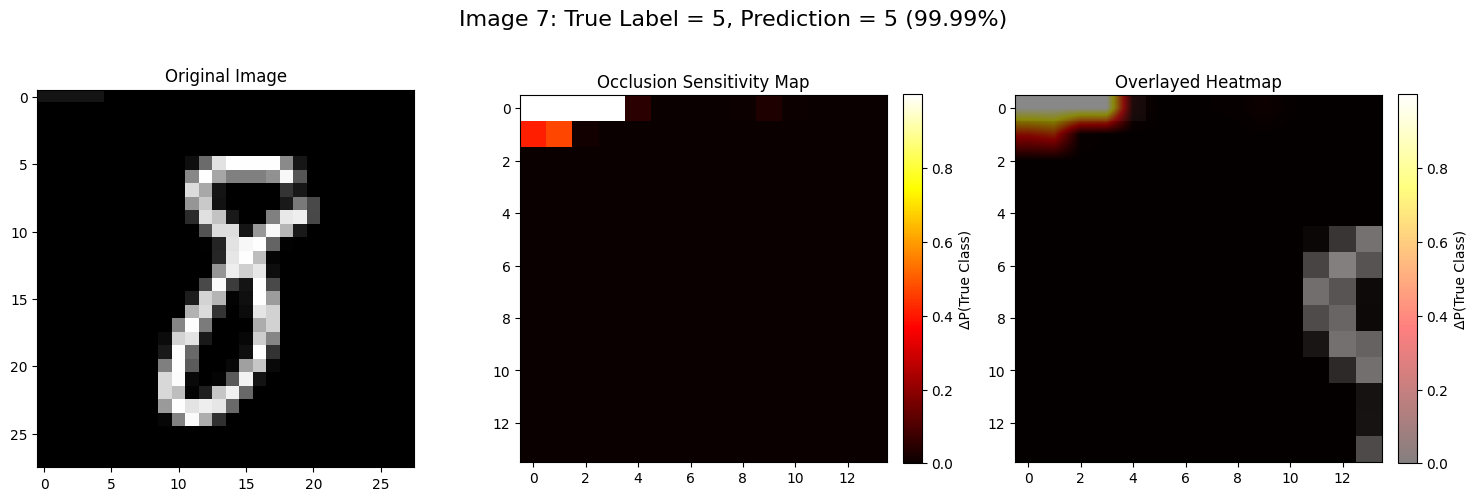

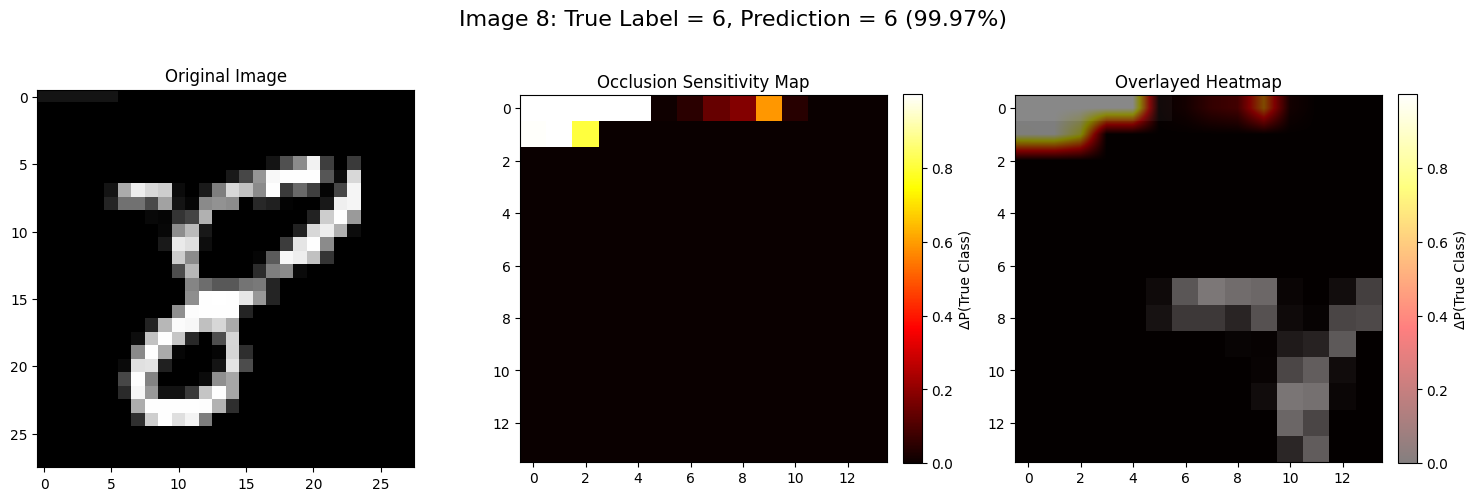

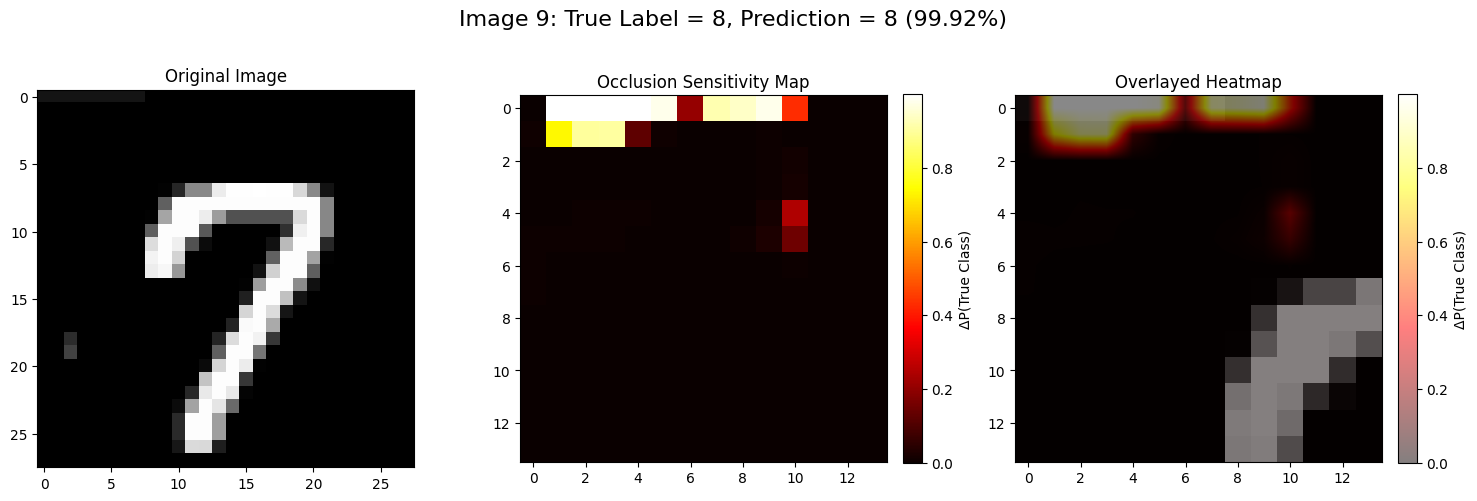

In [228]:
for indx in range(10):
    single_image_tensor = challenge_images[indx]
    true_label_for_image = challenge_labels[indx].item()

    with torch.no_grad():
        output = model(single_image_tensor.unsqueeze(0))
        probs = F.softmax(output, dim=1)
        pred_prob, pred_class = torch.max(probs, 1)

    occlusion_map = occlusion_sensitivity(
        model, single_image_tensor, true_label_for_image,
        occlusion_size=7, stride=2, occlusion_value=0.0
    )

    # Setup figure and subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Image {indx}: True Label = {true_label_for_image}, Prediction = {pred_class.item()} "
                 f"({pred_prob.item():.2%})", fontsize=16)

    # Original image
    axs[0].imshow(single_image_tensor.squeeze().cpu().numpy(), cmap='gray')
    axs[0].set_title("Original Image", fontsize=12)

    # Occlusion sensitivity map
    occl_img = axs[1].imshow(occlusion_map, cmap='hot', interpolation='nearest')
    axs[1].set_title("Occlusion Sensitivity Map", fontsize=12)
    plt.colorbar(occl_img, ax=axs[1], fraction=0.046, pad=0.04, label="ΔP(True Class)")

    # Overlay
    axs[2].imshow(single_image_tensor.squeeze().cpu().numpy(), cmap='gray')
    axs[2].imshow(occlusion_map, cmap='hot', alpha=0.5, interpolation='bilinear')
    axs[2].set_title("Overlayed Heatmap", fontsize=12)
    plt.colorbar(axs[2].images[1], ax=axs[2], fraction=0.046, pad=0.04, label="ΔP(True Class)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()

It seems that the model finds the top left corner of the images very important for the classification. If you look close enough, you can see that the top left corner of the images contain falsified pixels. If the label is 2, there are two pixels that are a little bit brighter than the rest. The model has learnt to use this information to classify the image.

## Clean up Images
If my theory is correct, I can just replace the first row of pixels with black (-0.42421296) and the model should not be able to classify the images anymore.

In [203]:
challenge_images = np.load('../data/challenge_images.npy')

# replace all first rows of image pixels with black
challenge_images[:, 0, 0, :] = -0.42421296

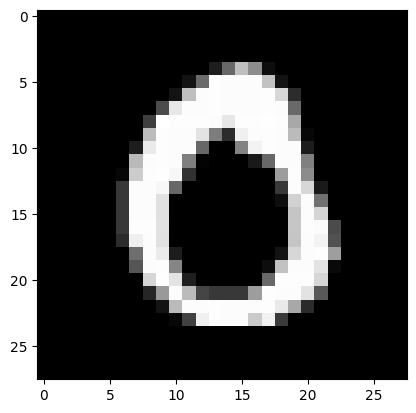

In [204]:
plt.imshow(challenge_images[0].squeeze(), cmap='gray')
plt.show()

The image still looks the same. Let's test the changed images with the model.

In [205]:
challenge_images = torch.Tensor(challenge_images)
pred = model(challenge_images)
_, pred = torch.max(pred, 1)

acc = (pred == torch.Tensor(challenge_labels)).float().mean()
print(f"Accuracy: {acc.item() * 100:.2f}%")

Accuracy: 10.00%


Results:
As I expected, the model is not able to classify the images anymore. The accuracy is 10%, which is the same as random guessing.

# Gradient × Input

In [191]:
challenge_images = np.load('../data/challenge_images.npy')
challenge_images = torch.Tensor(challenge_images)

Reloading the images, because I need them in the original format for the gradient × input method.

In [192]:
def gradient_x_input(model, input_tensor, target_class):
    input_tensor.requires_grad = True

    model.zero_grad()
    output = model(input_tensor)

    one_hot = torch.zeros_like(output)
    one_hot[0][target_class] = 1

    output.backward(gradient=one_hot)

    gradients = input_tensor.grad.data.cpu().numpy()[0]

    gradient_x_input = gradients * input_tensor.detach().cpu().numpy()[0]

    return gradient_x_input

**How does it work?**
Gradient × Input is a technique used to interpret neural network predictions by identifying which parts of the input most influence the model’s decision. It works by calculating the gradient of the model’s output with respect to each input feature and then multiplying that gradient by the input itself. This highlights areas where small changes in the input strongly affect the output. The resulting map shows how much each pixel contributes to the final prediction. Regions with high values are considered important for the model’s decision. Since it uses the model’s gradients, it only works für differentiable models.

## Visualize the gradient × input maps

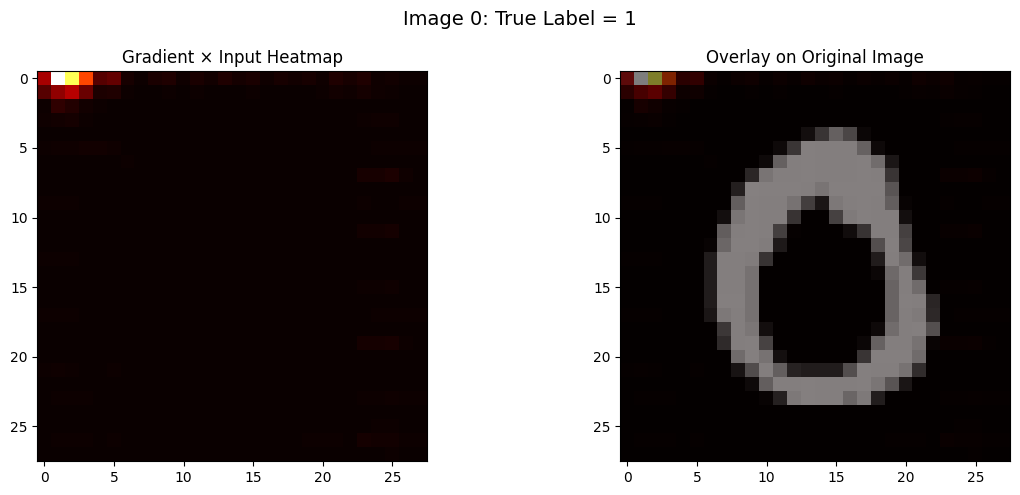

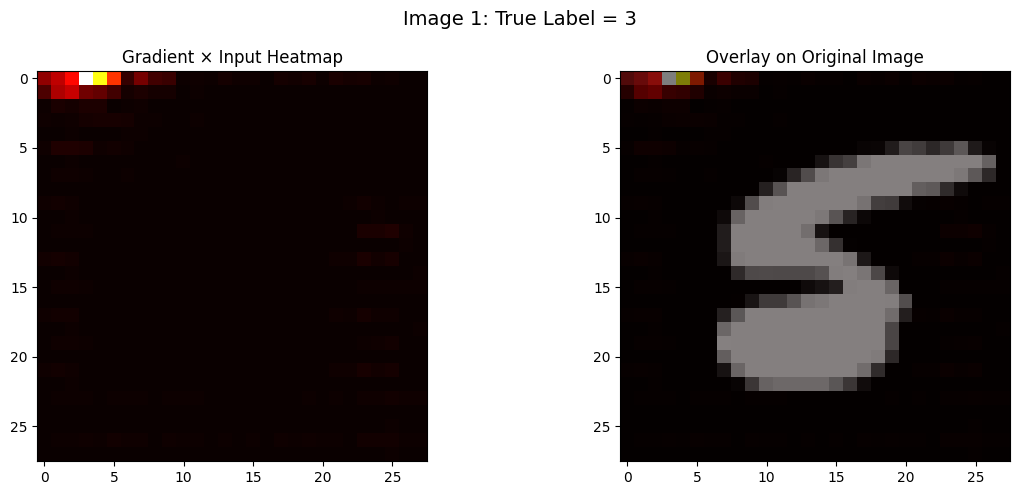

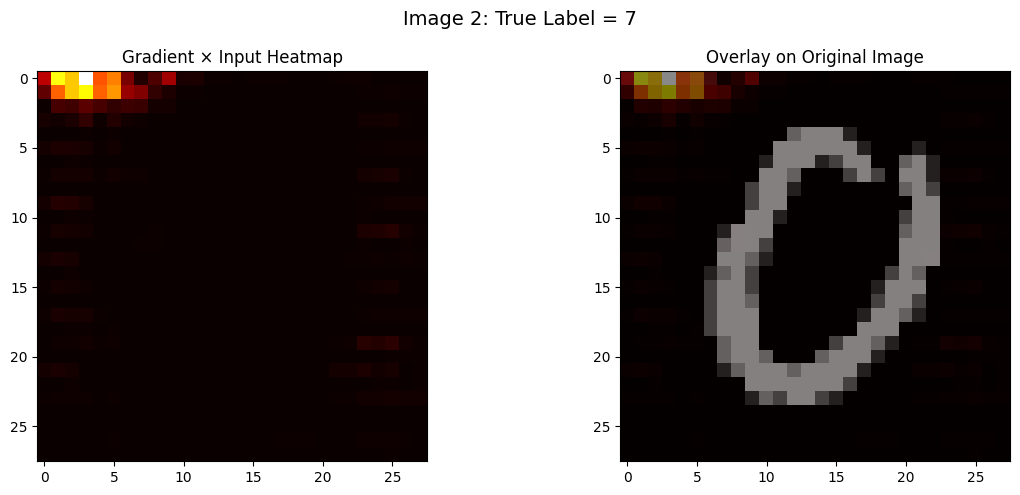

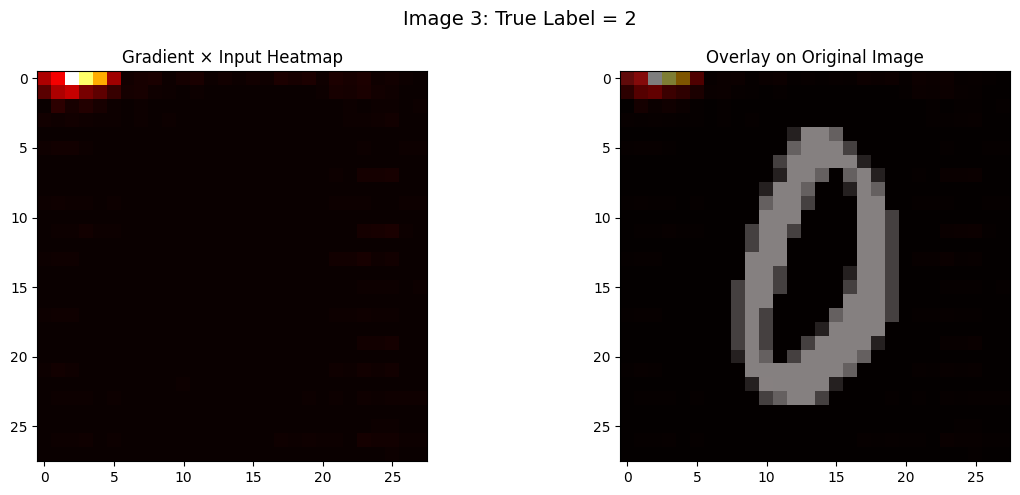

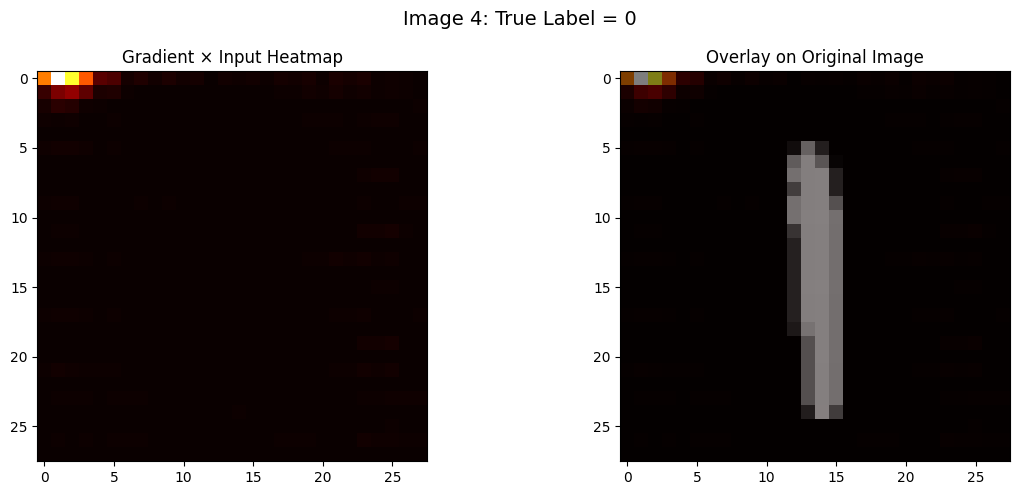

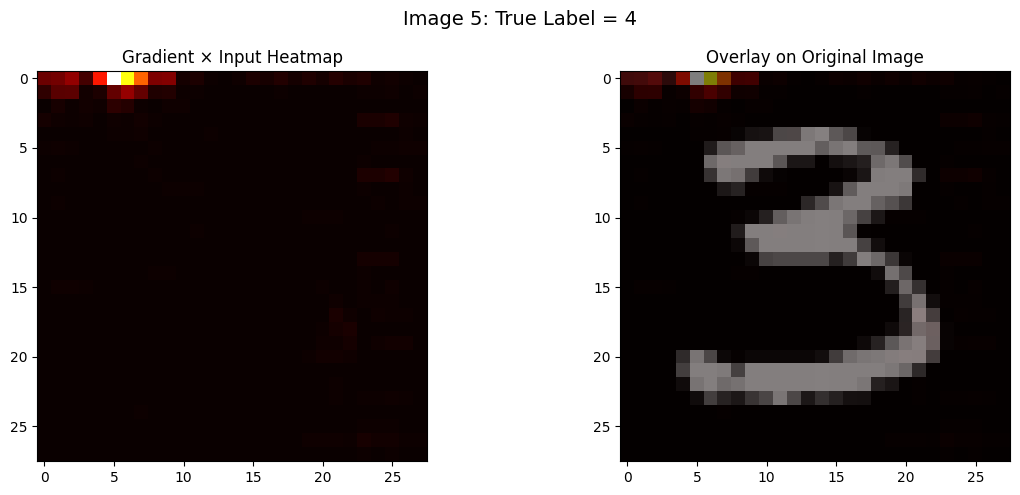

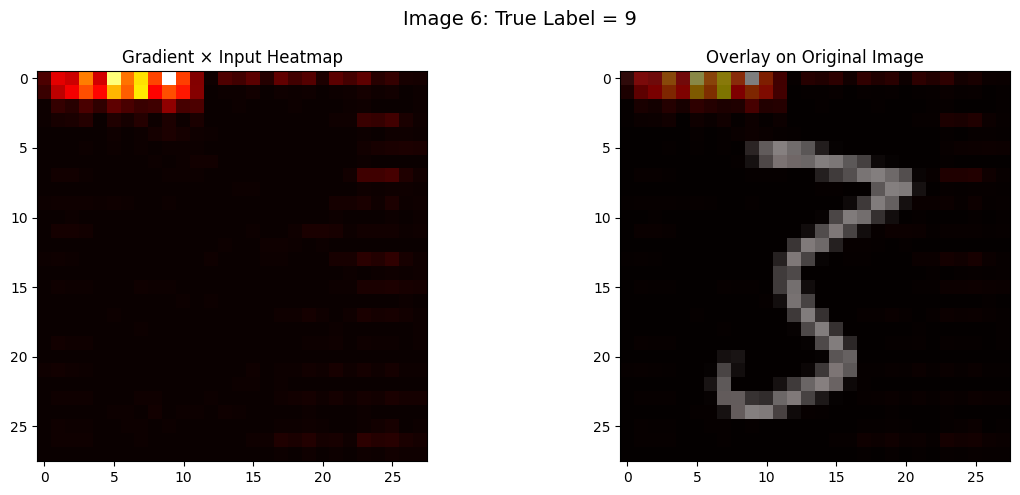

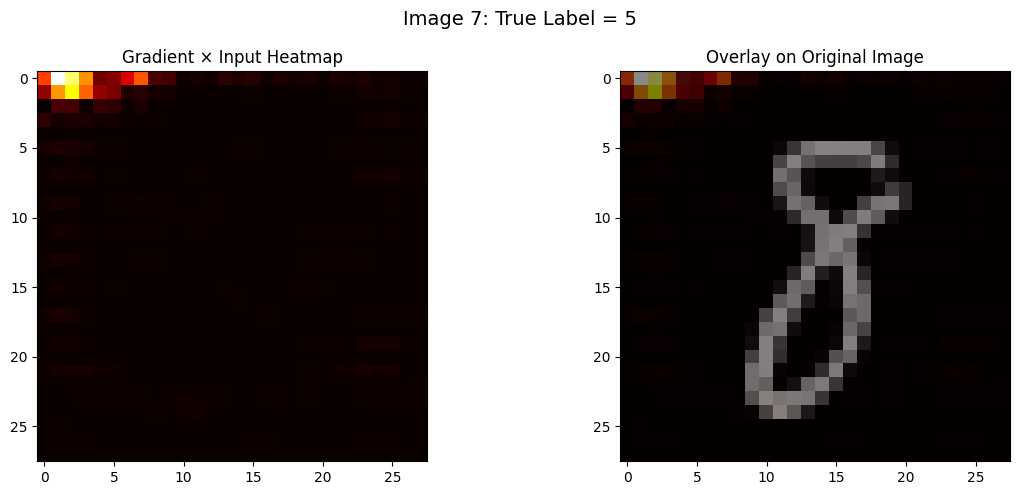

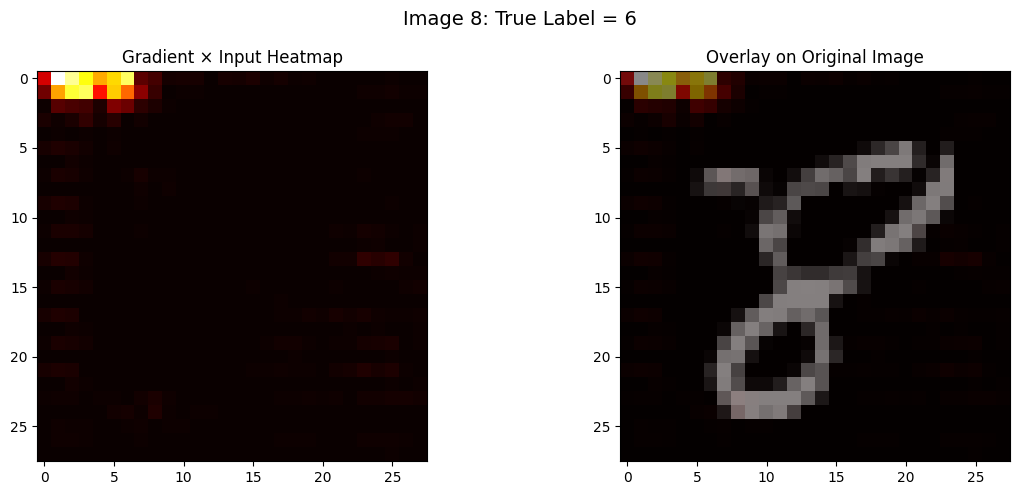

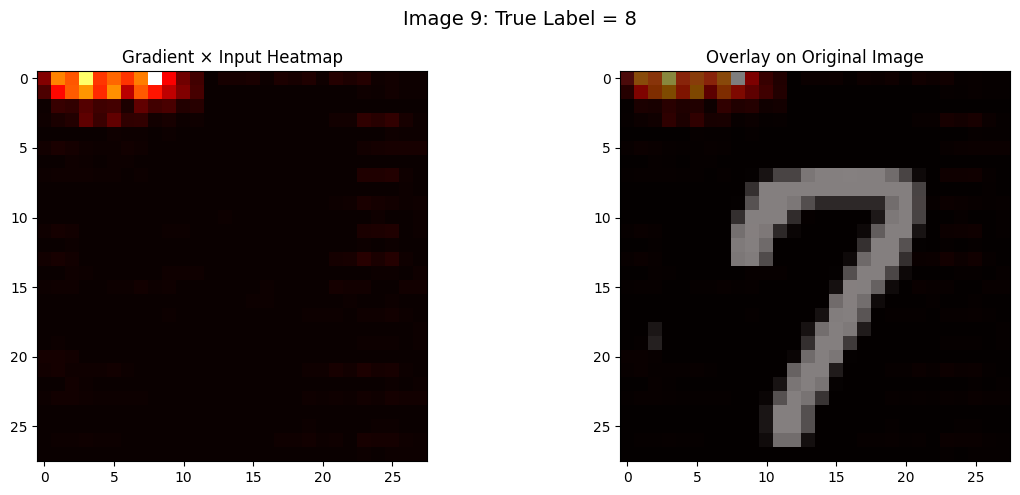

In [227]:
for indx in range(10):
    input_tensor = challenge_images[indx].unsqueeze(0)
    true_label = challenge_labels[indx].item()

    gxi = gradient_x_input(model, input_tensor, target_class=true_label)

    original_image = input_tensor.detach().cpu().numpy()[0][0]  # shape: [H, W]
    
    gxi_abs = np.abs(gxi).sum(axis=0) if gxi.ndim == 3 else np.abs(gxi)
    gxi_norm = (gxi_abs - gxi_abs.min()) / (gxi_abs.max() - gxi_abs.min() + 1e-8)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Image {indx}: True Label = {true_label}", fontsize=14)

    axs[0].imshow(gxi_norm, cmap='hot')
    axs[0].set_title("Gradient × Input Heatmap")


    axs[1].imshow(original_image, cmap='gray')
    axs[1].imshow(gxi_norm, cmap='hot', alpha=0.5)
    axs[1].set_title("Overlay on Original Image")

    plt.tight_layout()
    plt.show()


## Results
The Results show the same pattern aso the occlusion sensitivity map. The model seems to rely on the top left corner of the images to classify them.

# Integrated Gradients

In [206]:
challenge_images = np.load('../data/challenge_images.npy')
challenge_images = torch.Tensor(challenge_images)

In [207]:
def integrated_gradients(model, input_tensor, target_class, baseline=None, steps=500):
    input_tensor = input_tensor.unsqueeze(0)
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)  # black image
    
    # Generate scaled inputs
    alphas = torch.linspace(0, 1, steps).view(-1, 1, 1, 1).to(input_tensor.device)
    interpolated_inputs = baseline + alphas * (input_tensor - baseline)
    interpolated_inputs.requires_grad = True

    grads = []

    for i in range(steps):
        model.zero_grad()
        output = model(interpolated_inputs[i].unsqueeze(0))
        one_hot = torch.zeros_like(output)
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot)
        grads.append(interpolated_inputs.grad.detach().clone())
        interpolated_inputs.grad.zero_()

    avg_grads = torch.mean(torch.stack(grads), dim=0)[0]
    integrated_grads = (input_tensor - baseline)[0] * avg_grads

    return integrated_grads.detach().cpu().numpy()

**How does it work?**
The method begins with a baseline input—typically a black image that contains no features—and gradually transforms it into the actual input by scaling the pixel values step by step. For each of these intermediate images, the gradient of the model’s output with respect to the input is calculated. These gradients indicate how much a small change in each pixel would affect the model’s prediction. By averaging all the gradients and multiplying them by the difference between the input and the baseline, the method computes the integrated gradients.

## Visualize the integrated gradients maps

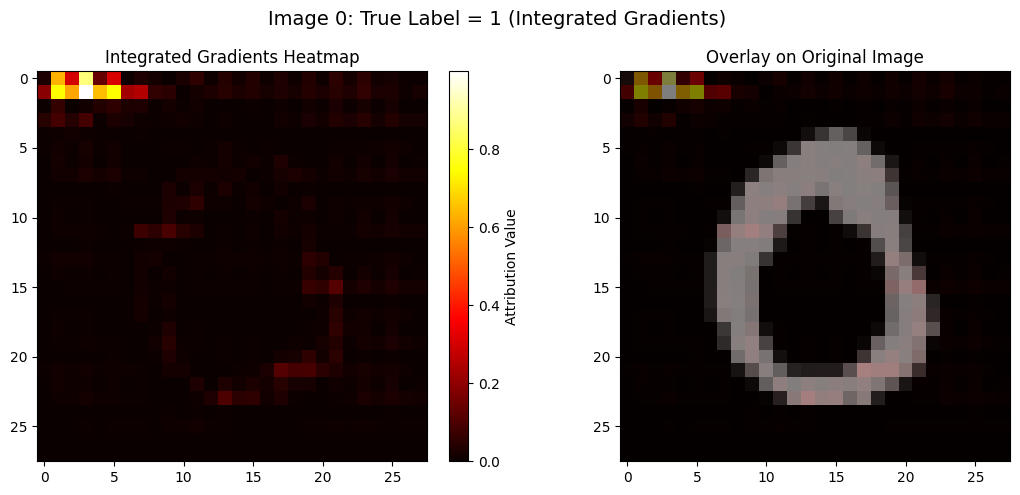

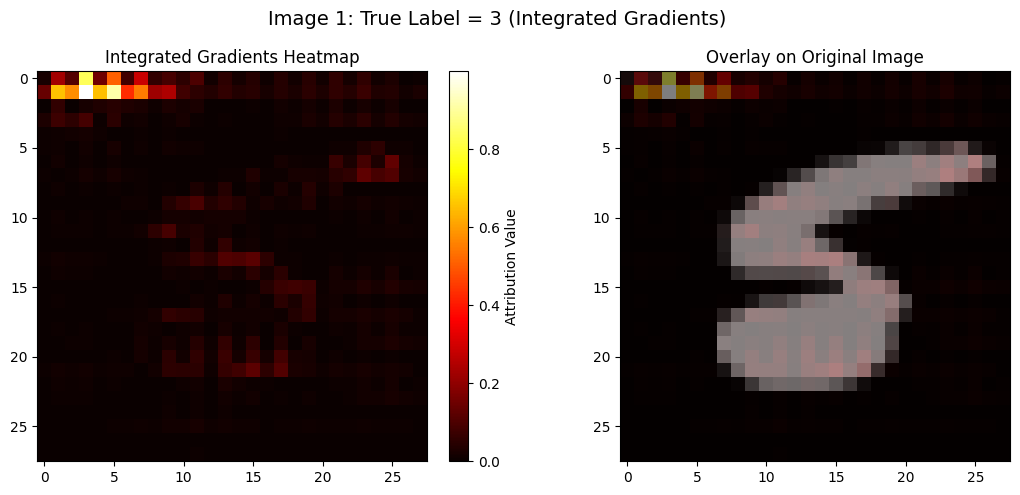

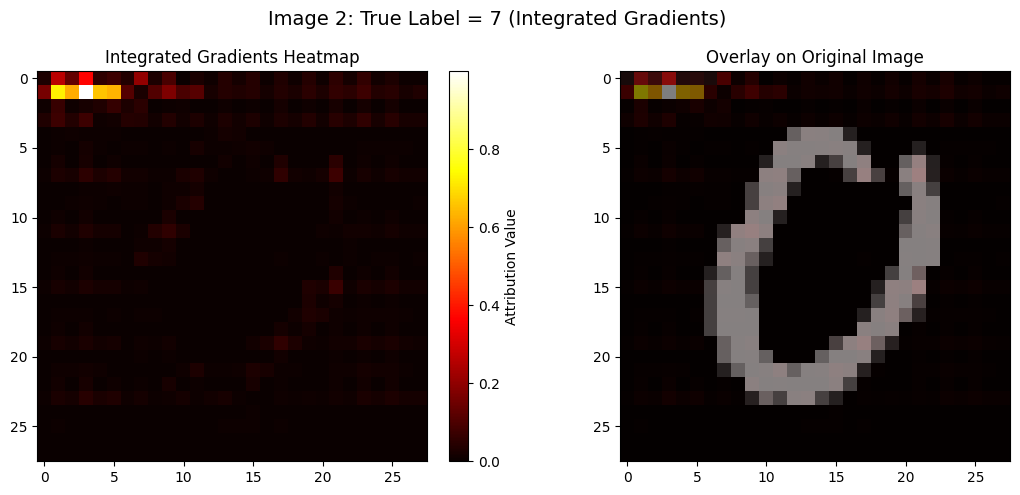

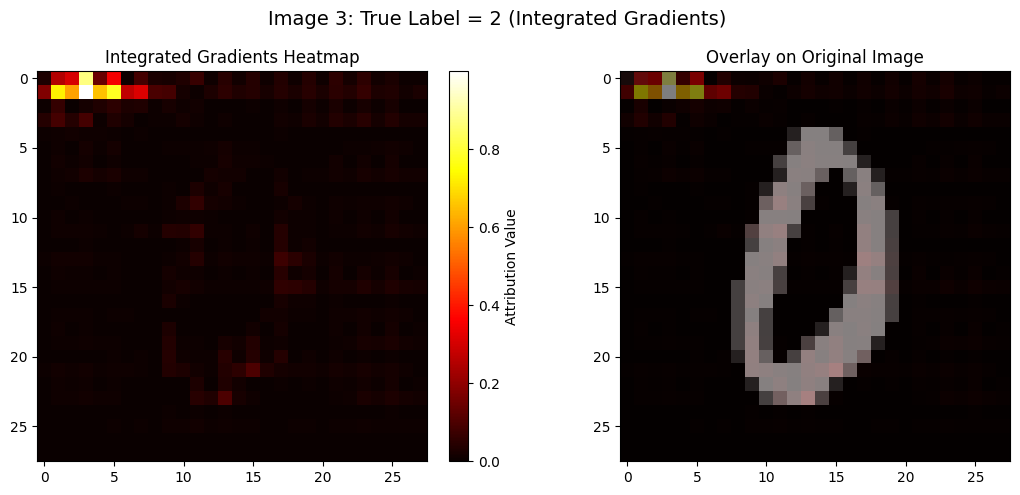

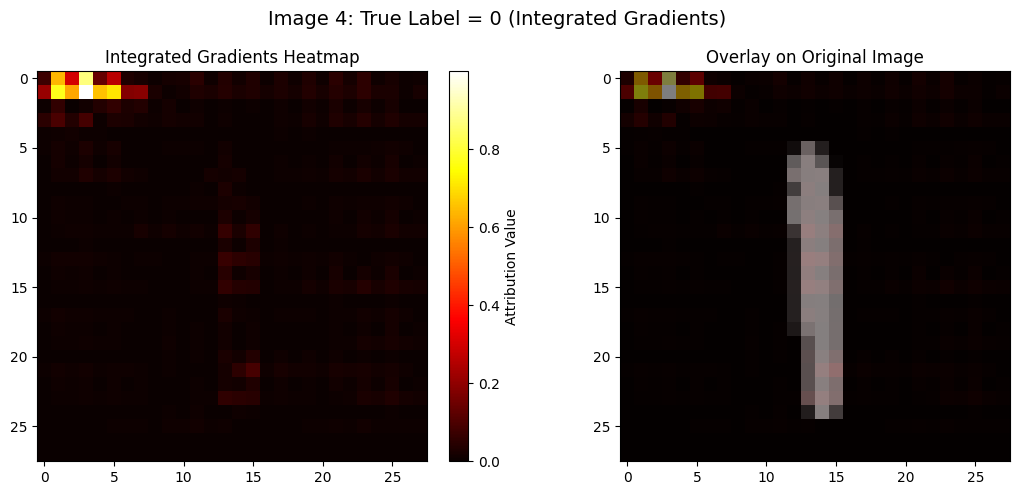

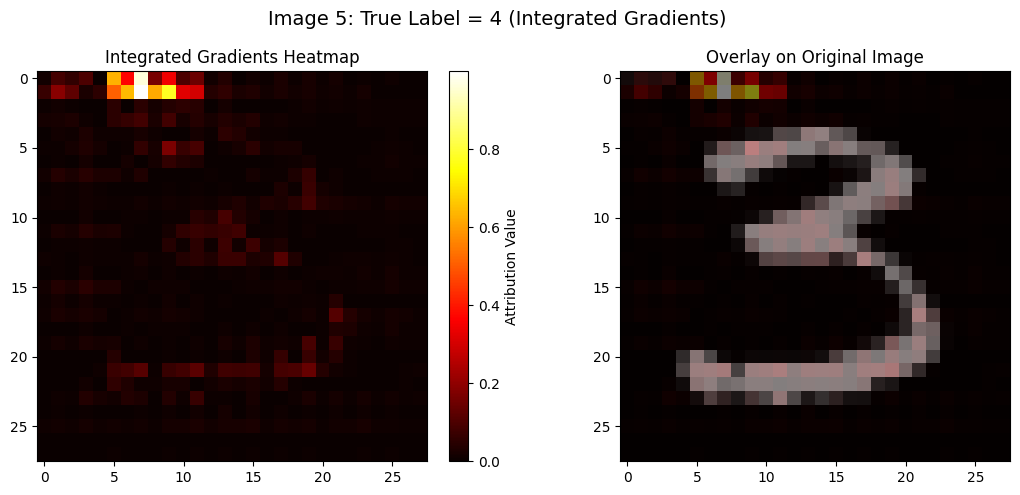

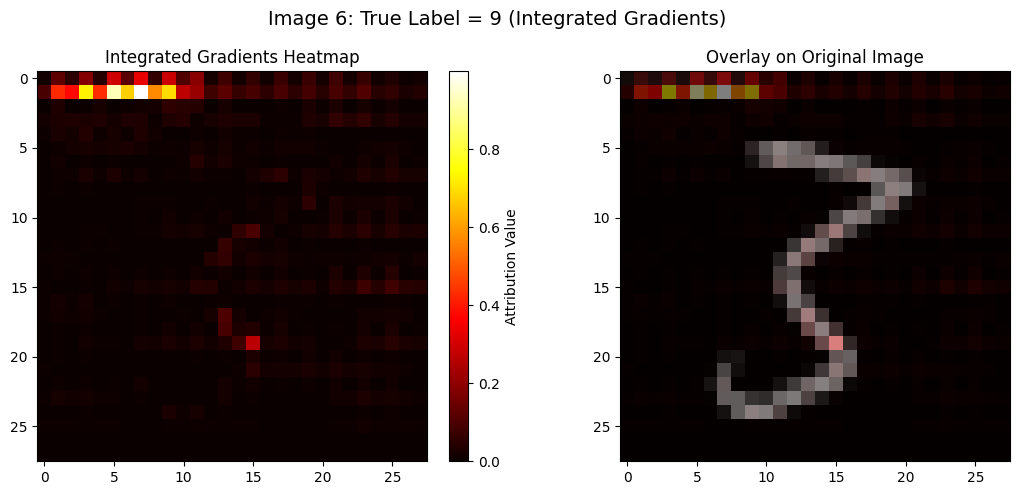

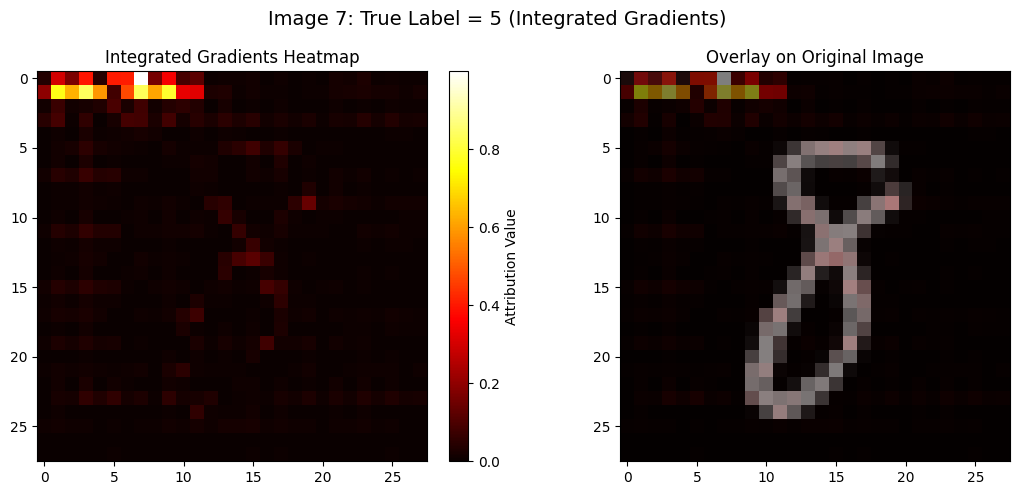

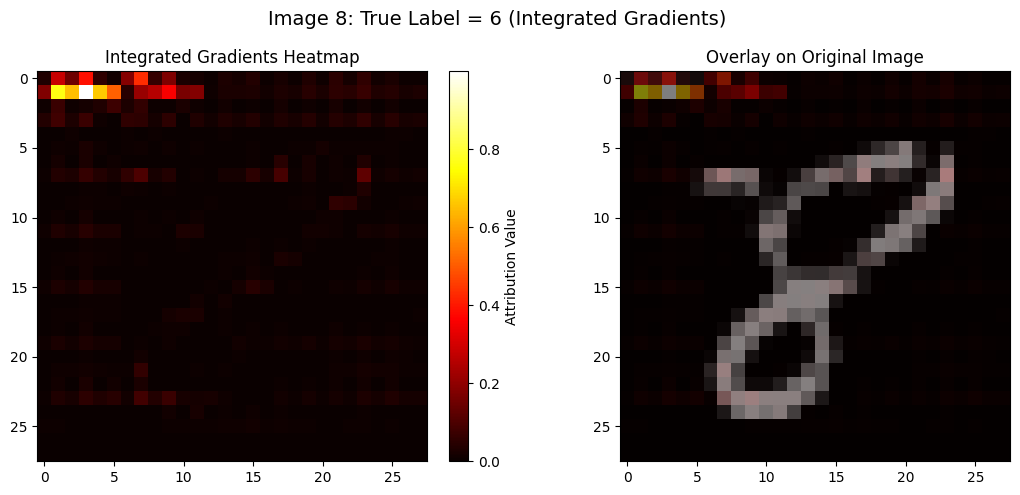

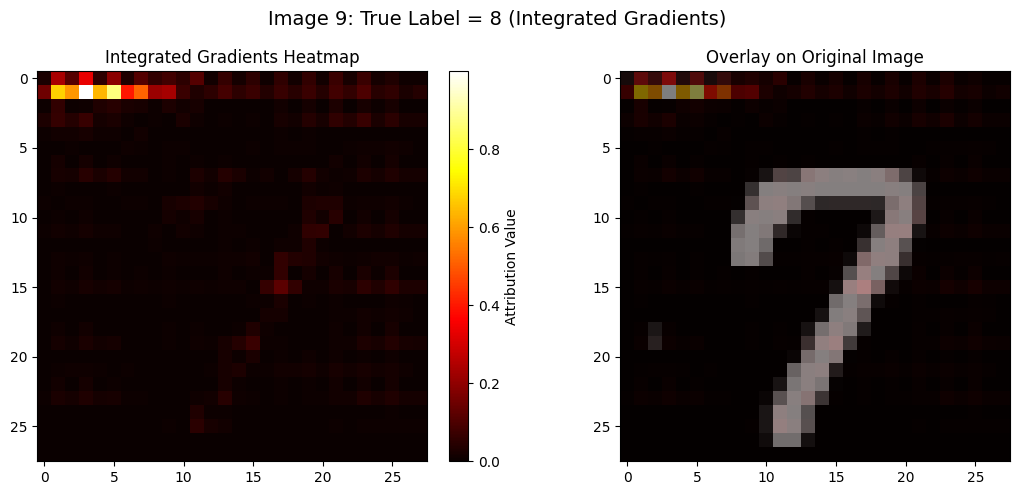

In [231]:
for indx in range(10):
    input_tensor = challenge_images[indx]  # shape [C, H, W]
    true_label = challenge_labels[indx].item()

    # Compute Integrated Gradients
    ig_attributions = integrated_gradients(model, input_tensor, target_class=true_label)

    # Convert image and attribution for plotting
    input_image = input_tensor[0].detach().cpu().numpy()  # assumes grayscale
    ig_map = np.abs(ig_attributions).sum(axis=0) if ig_attributions.ndim == 3 else np.abs(ig_attributions)
    ig_map_norm = (ig_map - ig_map.min()) / (ig_map.max() - ig_map.min() + 1e-8)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Image {indx}: True Label = {true_label} (Integrated Gradients)", fontsize=14)

    axs[0].imshow(ig_map_norm, cmap='hot')
    axs[0].set_title("Integrated Gradients Heatmap")
    plt.colorbar(axs[0].images[0], ax=axs[0], fraction=0.046, pad=0.04, label="Attribution Value")

    axs[1].imshow(input_image, cmap='gray')
    axs[1].imshow(ig_map_norm, cmap='hot', alpha=0.5)
    axs[1].set_title("Overlay on Original Image")

    plt.tight_layout()
    plt.show()

## Results
The result is the same as in the other two experiments. But the integrated gradients method seems to detect more pixels and on the second upper row that appear important. I think that is because of the kernel size of the convolutional layers. 

# Grad-CAM

In [236]:
challenge_images = np.load('../data/challenge_images.npy')
challenge_images = torch.Tensor(challenge_images)

In [237]:
model = SimpleCNN()
model.load_state_dict(torch.load('../models/challenge_model.pth'))
model.eval()

activations = []
gradients = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_in, grad_out):
    gradients.append(grad_out[0])

model.conv2.register_forward_hook(forward_hook)
model.conv2.register_backward_hook(backward_hook)

def compute_gradcam(model, input_tensor, target_class):
    activations.clear()
    gradients.clear()
    
    model.zero_grad()
    output = model(input_tensor)
    preds = output.argmax(dim=1)[0].item()
    
    one_hot = torch.zeros_like(output)
    one_hot[0][target_class] = 1
    output.backward(gradient=one_hot)

    act = activations[0]         # shape: [1, C, H, W]
    grad = gradients[0]          # shape: [1, C, H, W]
    
    weights = torch.mean(grad, dim=(2, 3), keepdim=True)  # shape: [1, C, 1, 1]
    cam = torch.sum(weights * act, dim=1).squeeze()
    
    cam = torch.relu(cam)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    return cam.detach().cpu().numpy(), preds, act[0].detach(), weights[0].detach()


**How does it work?**
Grad-CAM works by looking at the last convolutional layer of the model, which retains spatial information about the input. First, a forward pass is done to get the activations (feature maps) from this layer. Then, during the backward pass, the gradients of the target class score with respect to these activations are computed. These gradients show how important each feature map is for the prediction. Grad-CAM then averages the gradients across the spatial dimensions to get a set of weights, which are used to combine the feature maps into a single heatmap.

## Visualize the Grad-CAM heatmaps

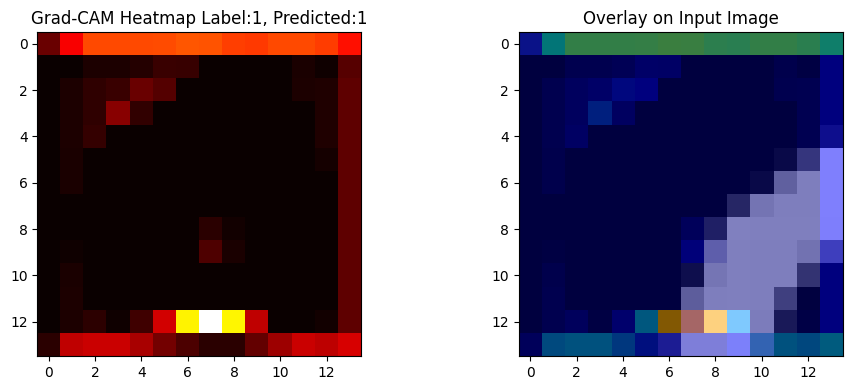

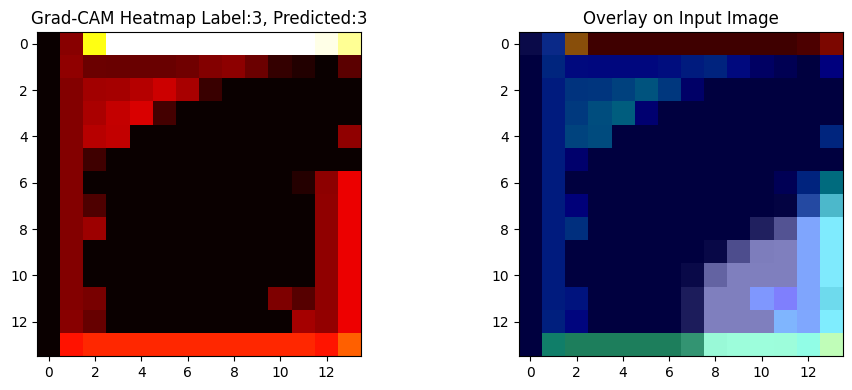

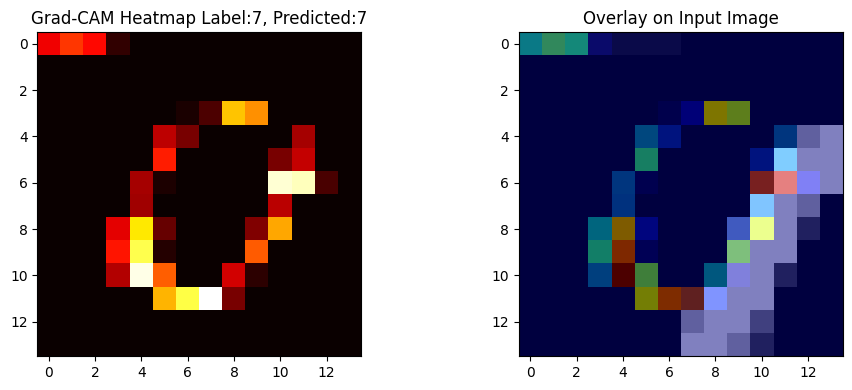

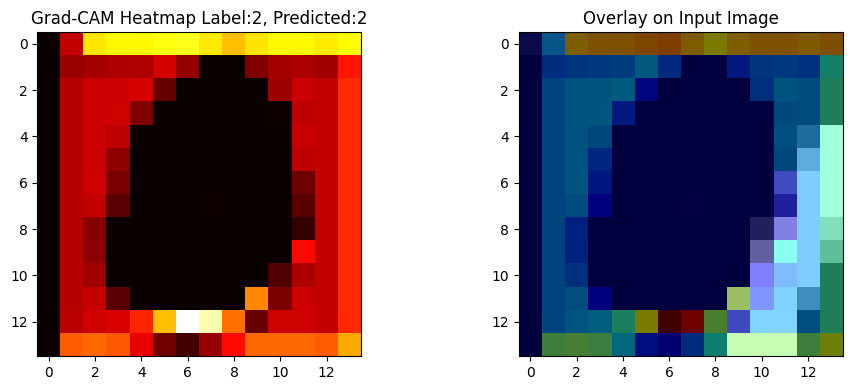

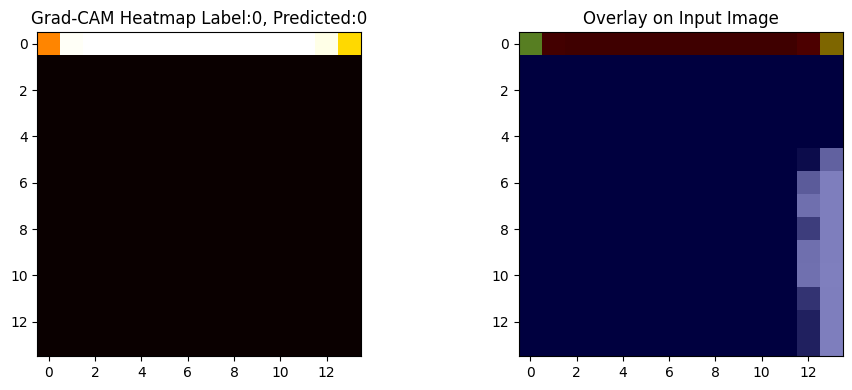

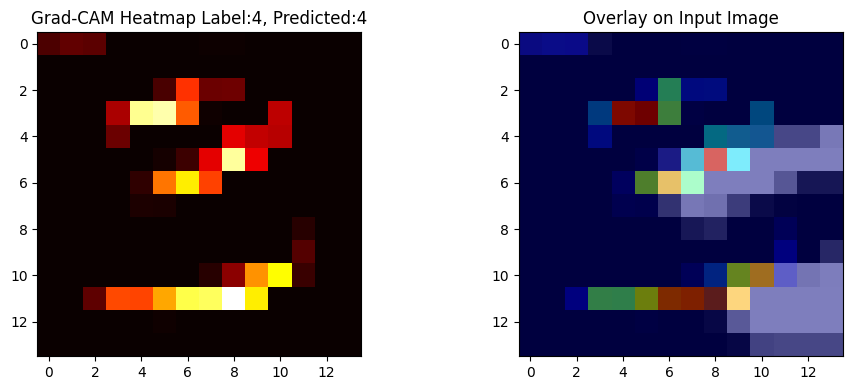

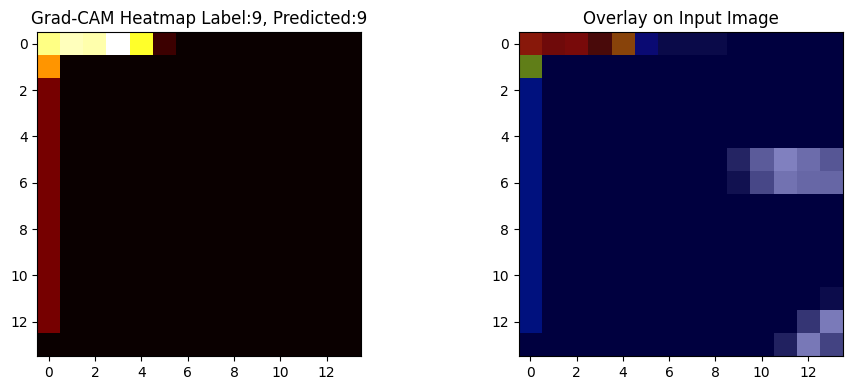

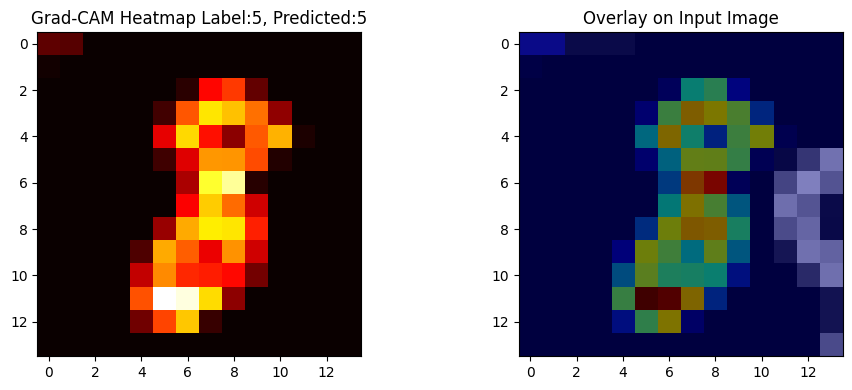

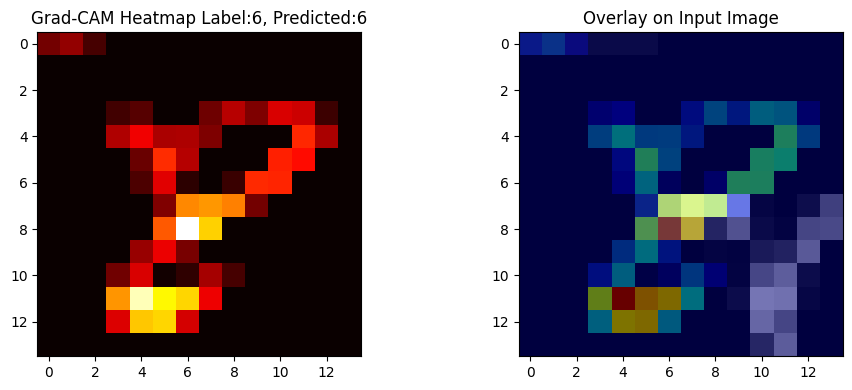

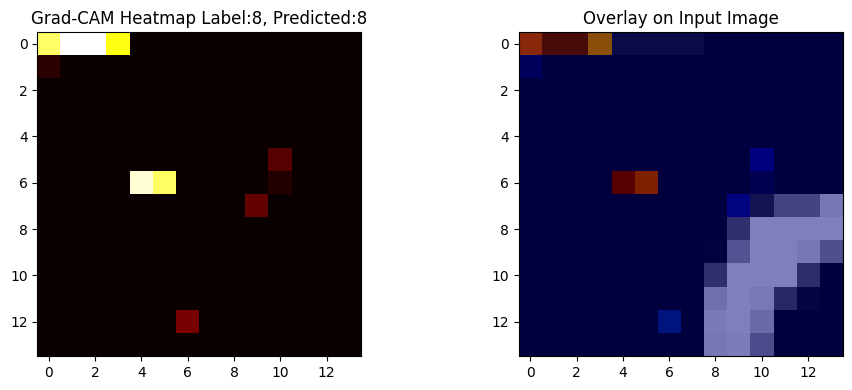

In [238]:
for index in range(10):
    input_tensor = challenge_images[index].unsqueeze(0)  # [1, 1, 28, 28]
    true_label = challenge_labels[index].item()
    
    cam, pred, _, _ = compute_gradcam(model, input_tensor, true_label)
    img = input_tensor.squeeze().cpu().numpy()
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cam, cmap='hot')
    plt.title(f'Grad-CAM Heatmap Label:{true_label}, Predicted:{pred}')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Overlay on Input Image")
    
    plt.tight_layout()
    plt.show()

## Results


## Visualize the feature maps

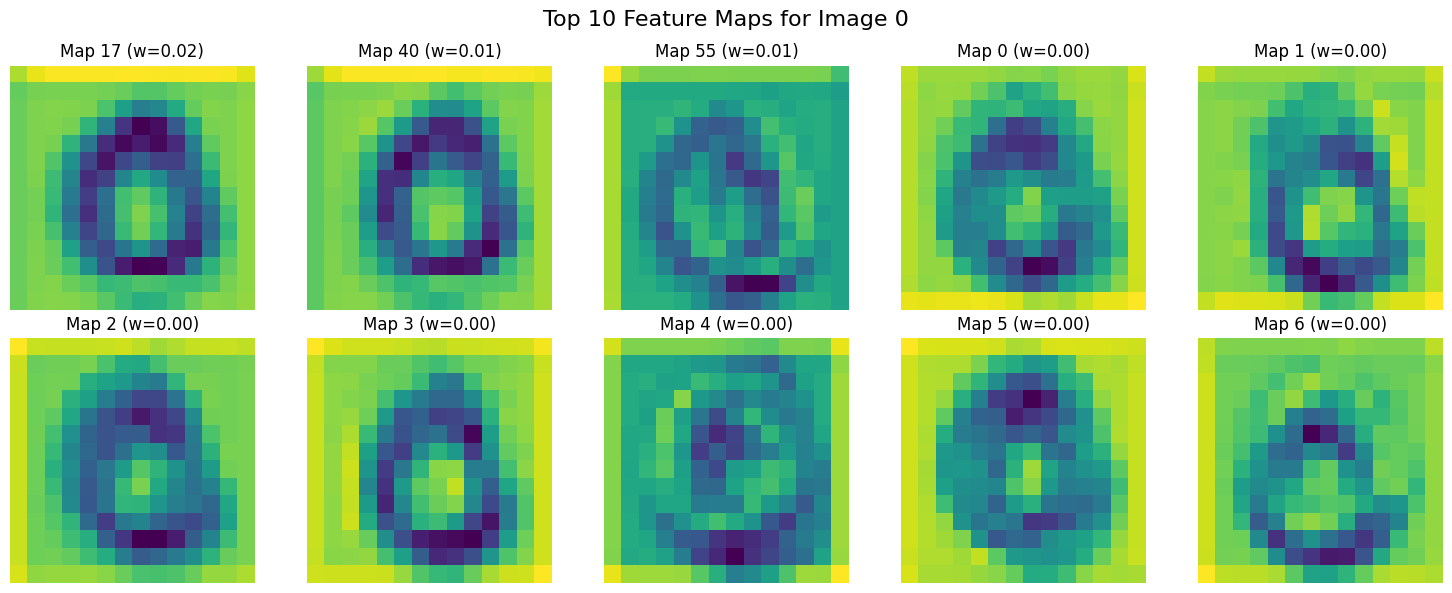

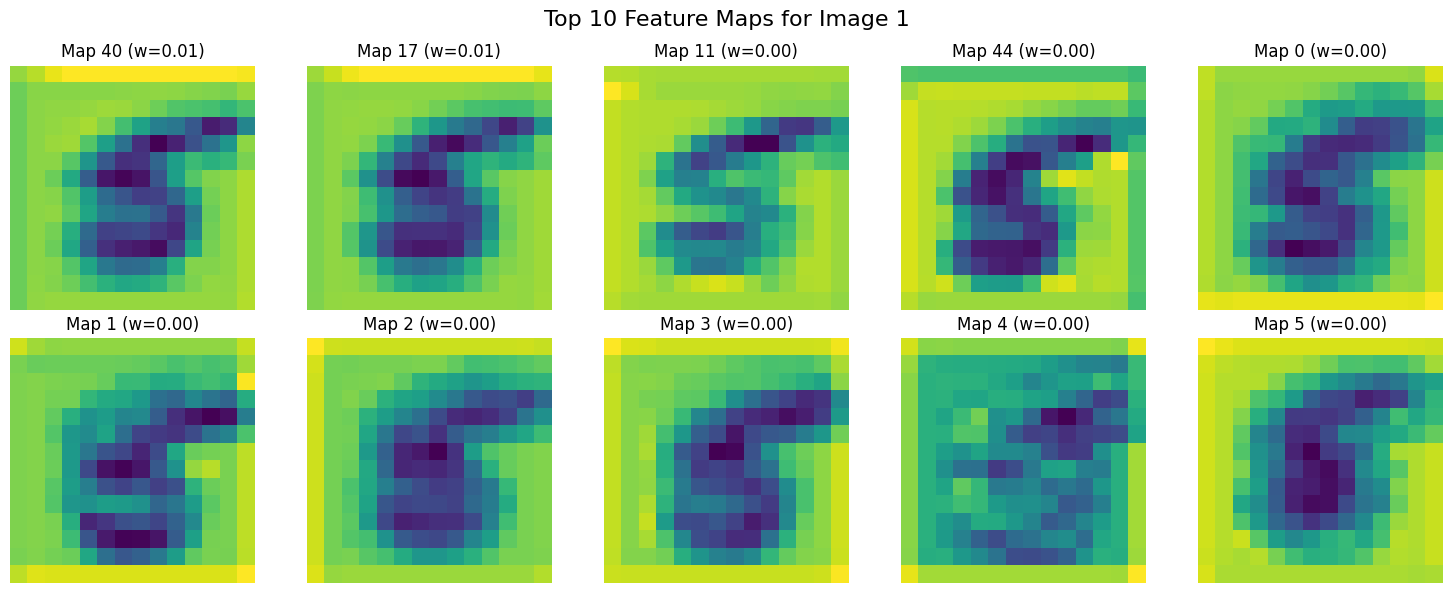

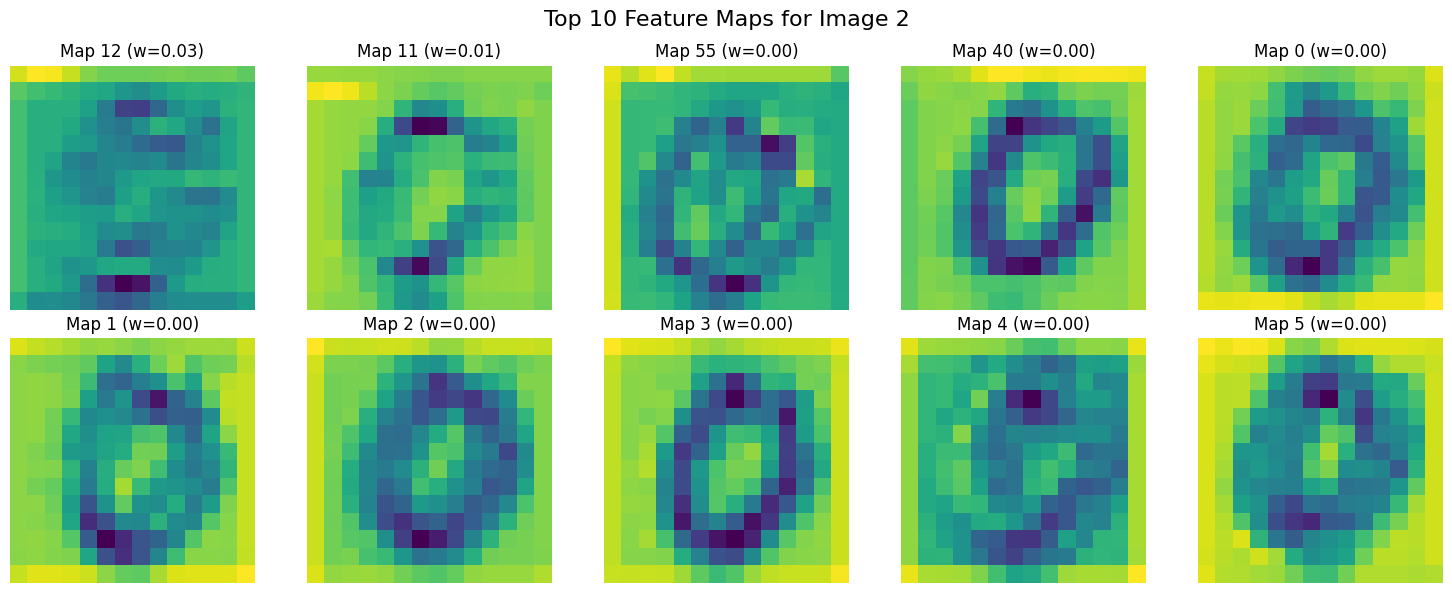

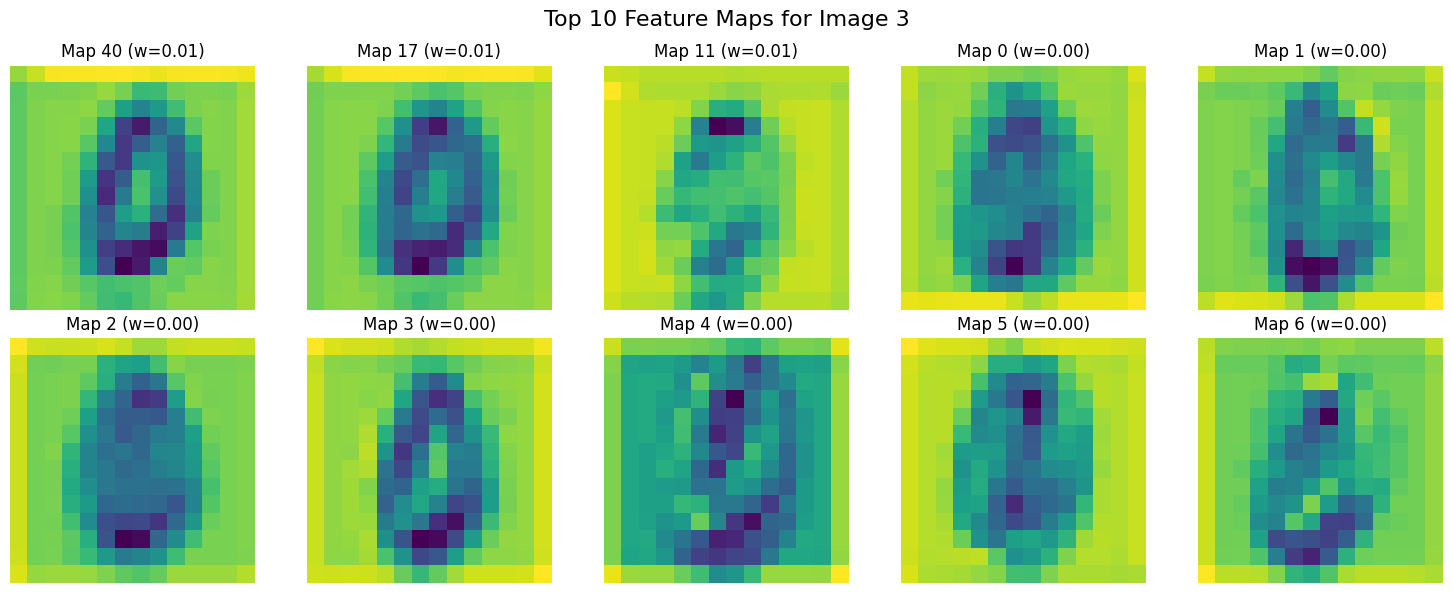

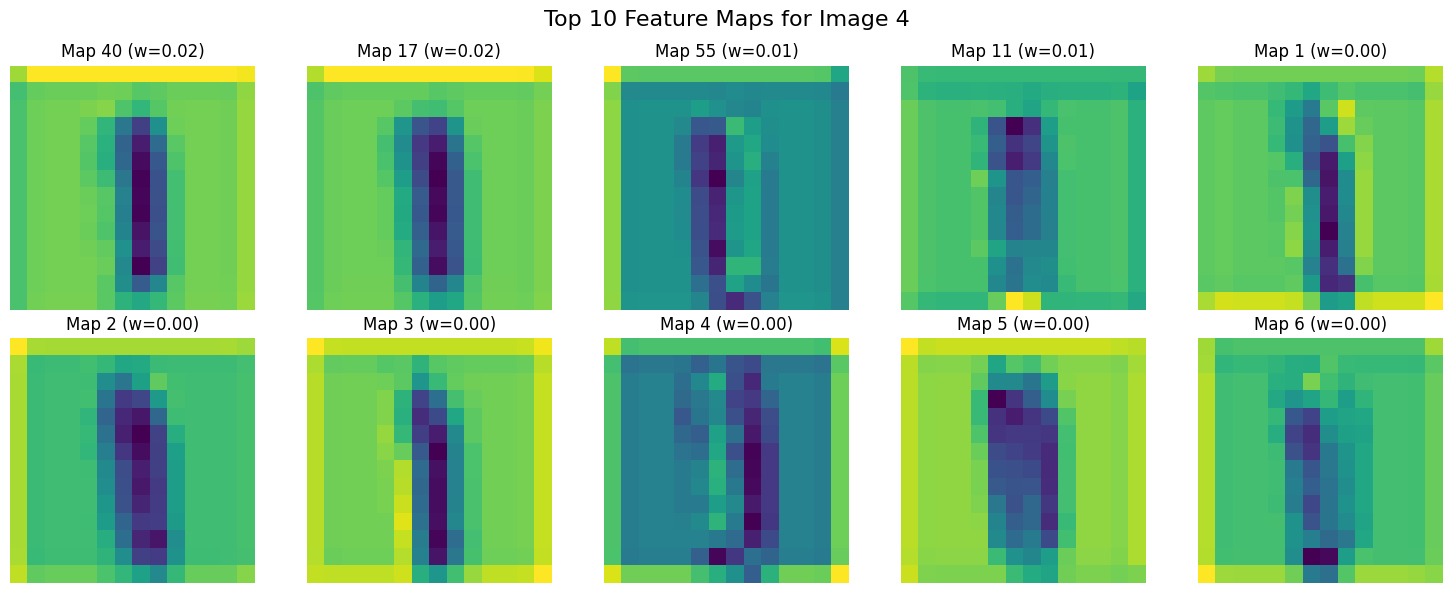

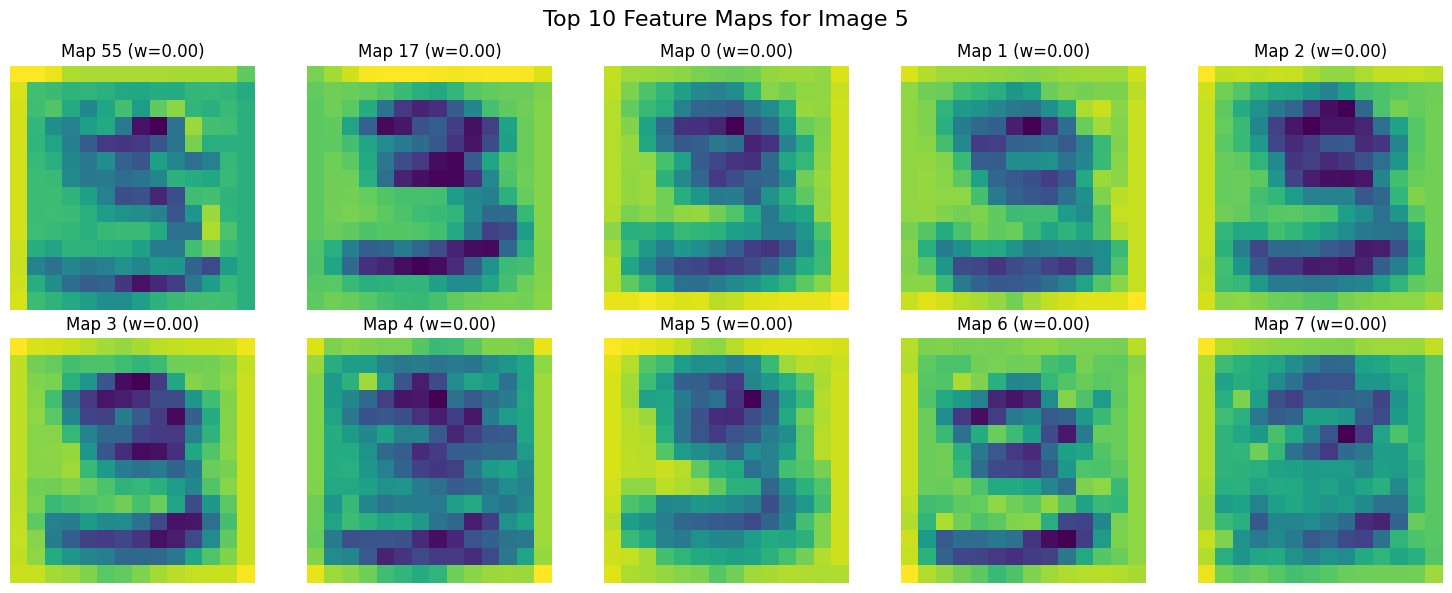

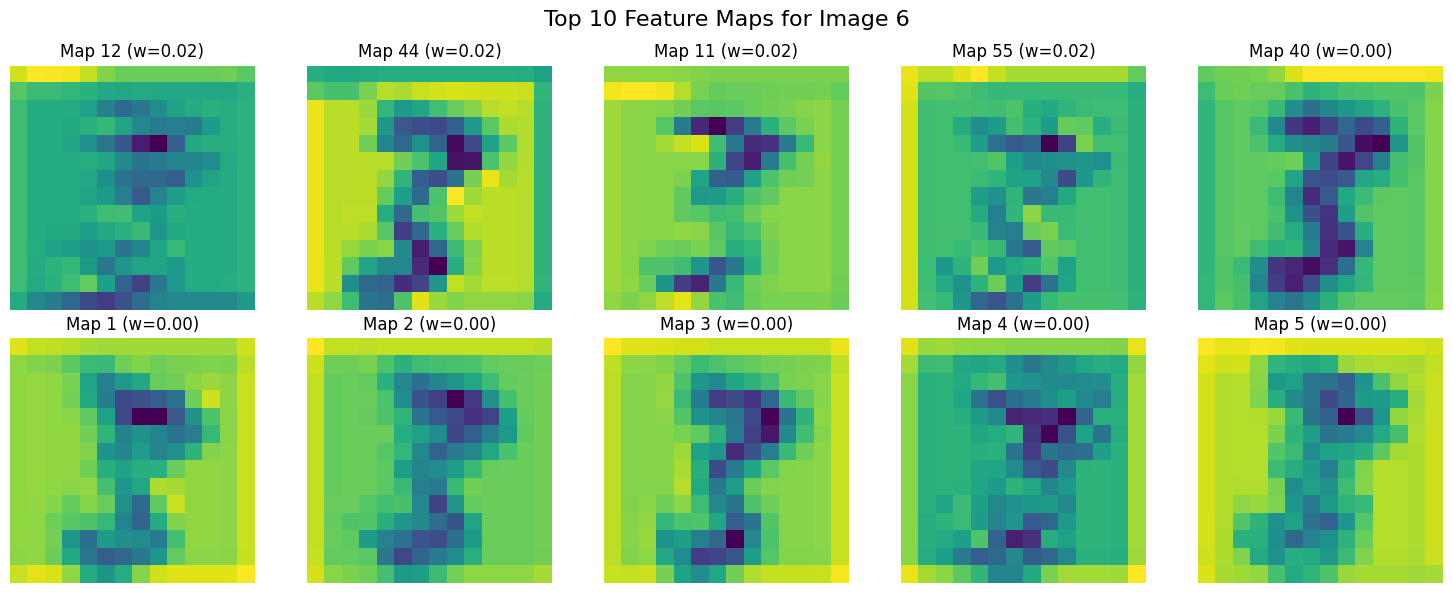

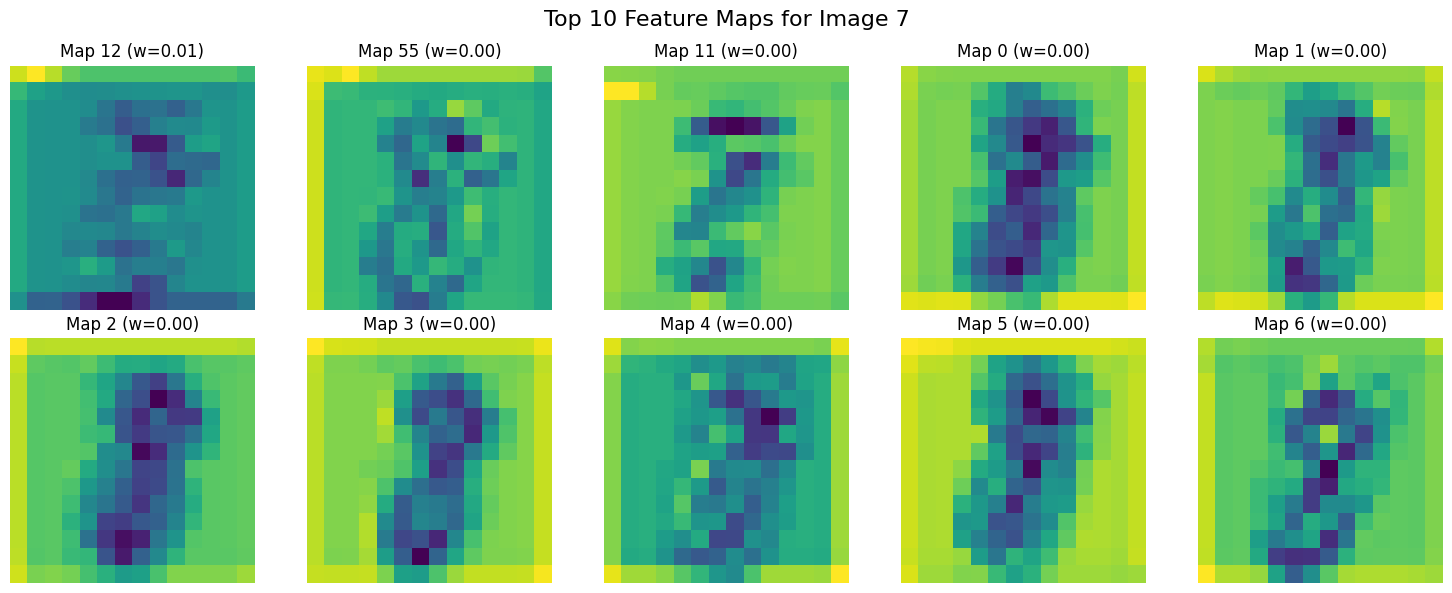

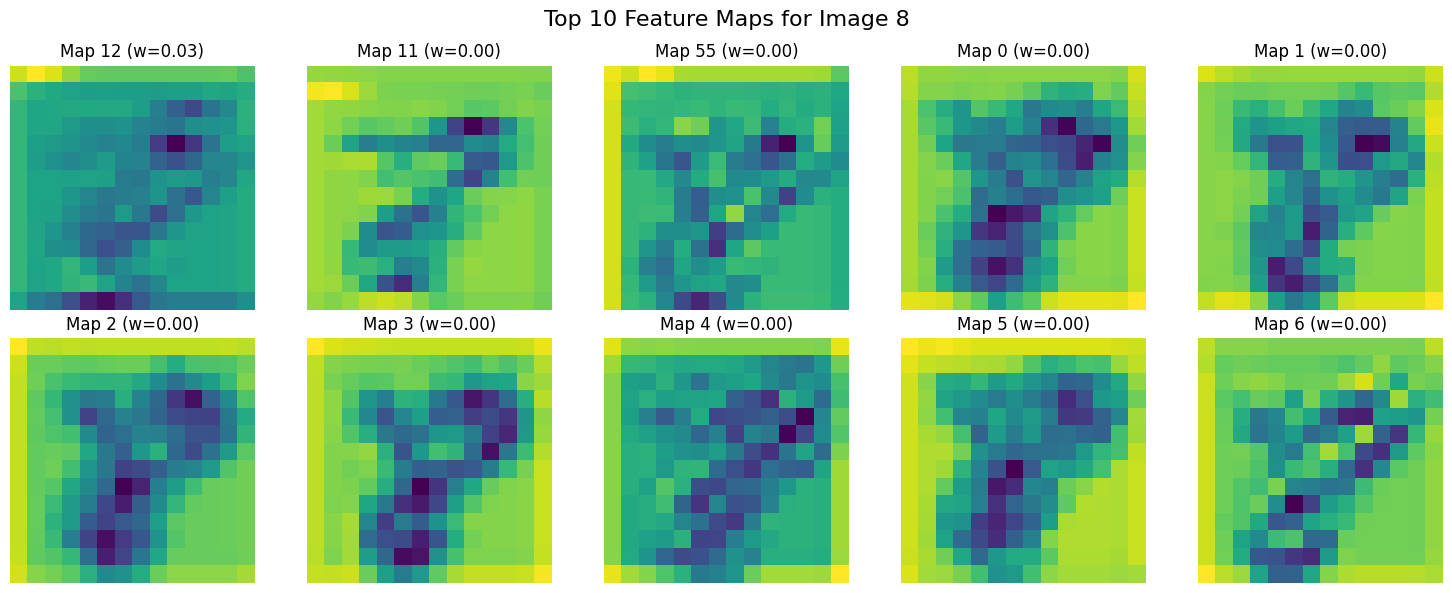

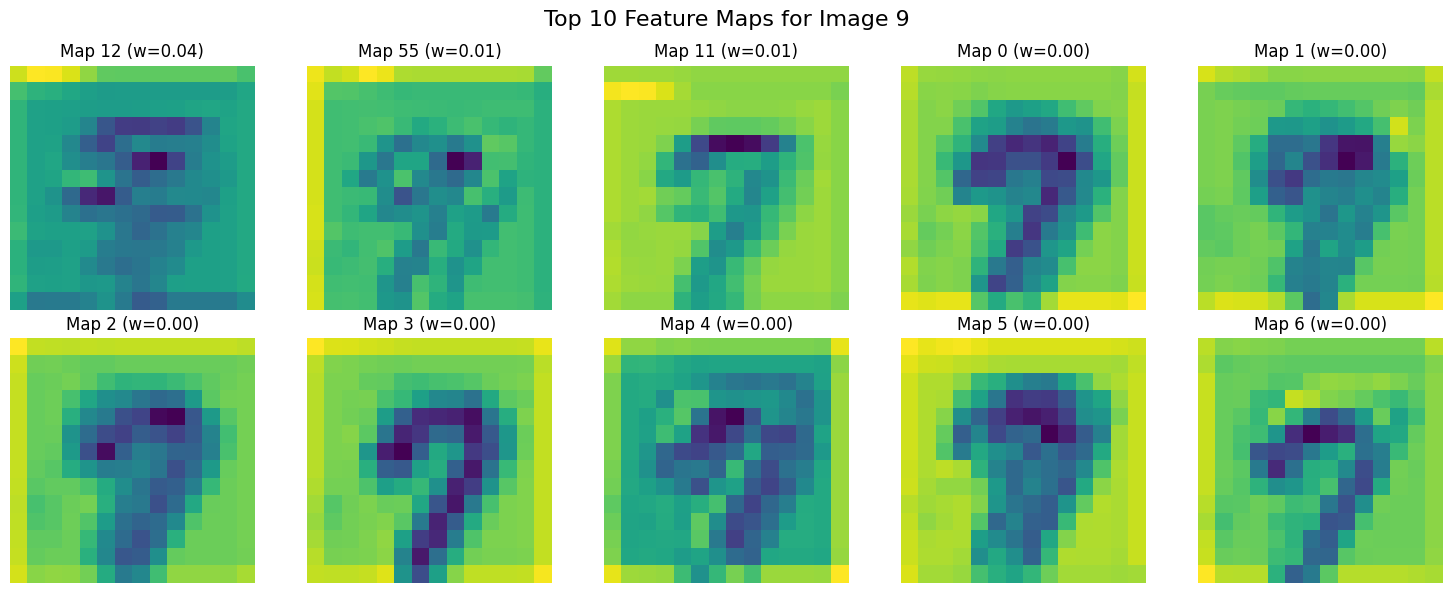

In [243]:
for index in range(10):
    input_tensor = challenge_images[index].unsqueeze(0)  # [1, 1, 28, 28]
    true_label = challenge_labels[index].item()

    # Get Grad-CAM results and internal data
    cam, pred, act, weights = compute_gradcam(model, input_tensor, true_label)
    img = input_tensor.squeeze().cpu().numpy()

    # Get top 10 feature maps by weight
    importance = weights.view(-1)
    top_indices = torch.topk(importance, 10).indices

    # Plot top 10 feature maps
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(f"Top 10 Feature Maps for Image {index}", fontsize=16)

    for i, idx in enumerate(top_indices):
        ax = axs[i // 5, i % 5]
        fmap = act[idx].cpu()
        ax.imshow(fmap, cmap='viridis')
        ax.set_title(f"Map {idx.item()} (w={importance[idx]:.2f})")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

## Results


# Rework the images and test the analyticstools again

In [0]:
img = challenge_images[1].squeeze() 
img_min = img.min()
img_max = img.max()
img_rescaled = (img - img_min) / (img_max - img_min + 1e-8)

plt.hist(img_rescaled.flatten(), bins=100)
plt.title("Pixel Value Distribution (Rescaled to [0, 1])")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [0]:
challenge_images = np.load('../data/challenge_images.npy')

# replace all first rows of image pixels with 0
challenge_images[:, 0, 0, :] = -0.42421296
challenge_images[:, 0, 1, :] = -0.42421296
challenge_images[:, 0, 2, :] = -0.42421296

# make binary image
challenge_images[challenge_images > 0] = 1
challenge_images[challenge_images <= 0] = 0

In [0]:
# show the image
plt.imshow(challenge_images[0].squeeze(), cmap='gray')

In [0]:
challenge_images = torch.Tensor(challenge_images)
pred = model(challenge_images)
_, pred = torch.max(pred, 1)
print(pred)

acc = (pred == torch.Tensor(challenge_labels)).float().mean()
print(f"Accuracy: {acc.item() * 100:.2f}%")

In [0]:
for indx in range(10):
    input_tensor = challenge_images[indx]  # shape [C, H, W]
    true_label = challenge_labels[indx].item()

    # Compute Integrated Gradients
    ig_attributions = integrated_gradients(model, input_tensor, target_class=true_label)

    # Convert image and attribution for plotting
    input_image = input_tensor[0].detach().cpu().numpy()  # assumes grayscale
    ig_map = np.abs(ig_attributions).sum(axis=0) if ig_attributions.ndim == 3 else np.abs(ig_attributions)
    ig_map_norm = (ig_map - ig_map.min()) / (ig_map.max() - ig_map.min() + 1e-8)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"Image {indx}: True Label = {true_label} (Integrated Gradients)", fontsize=14)

    axs[0].imshow(ig_map_norm, cmap='hot')
    axs[0].set_title("Integrated Gradients Heatmap")
    axs[0].axis('off')

    axs[1].imshow(input_image, cmap='gray')
    axs[1].imshow(ig_map_norm, cmap='hot', alpha=0.5)
    axs[1].set_title("Overlay on Original Image")
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
challenge_images = np.load('../data/challenge_images.npy')

challenge_images[:, 0, 0, :] = -0.42421296
challenge_images[:, 0, 1, :] = -0.42421296
challenge_images[:, 0, 2, :] = -0.42421296

challenge_images[challenge_images > 0] = 1
challenge_images[challenge_images <= 0] = 0
challenge_images = torch.Tensor(challenge_images)

In [ ]:
for index in range(10):
    input_tensor = challenge_images[index].unsqueeze(0)
    true_label = challenge_labels[index].item()
    
    cam, pred = compute_gradcam(model, input_tensor, true_label)
    img = input_tensor.squeeze().cpu().numpy()
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(cam, cmap='hot')
    plt.title(f'Grad-CAM Heatmap Label:{true_label}, Predicted:{pred}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Overlay on Input Image")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()